# Final Pipeline

## 0.Imports

In [61]:
import sys
import os
import numpy as np
import pandas as pd
import random
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr


import shapefile as sh
import geopandas as gpd
from shapely.geometry import LineString, MultiPolygon, Polygon, box, MultiPoint, Point
from shapely import wkt
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

from platform import python_version
print(f"Py v{python_version()}")

Loading BokehJS ...

Py v3.8.10


## 1. Exploratory Data Analysis (EDA)

### 1.1 DATA PATHS
`

In [2]:
# NetCDF DATA_PATH
path_01_nc = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'
path_02_nc = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Snow_500m.nc'
path_01_geoTIFF = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/MOD11A1.006_LST_Night_1km_doy2022319_aid0001.tif'

### 1.1 GDAL reader

In [3]:
rds = gdal.Open(path_01_nc)
info = gdal.Info(rds, deserialize=True)
print(info) 

Driver: netCDF/Network Common Data Format
Files: /home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#history=See README.md
  NC_GLOBAL#institution=Land Processes Distributed Active Archive Center (LP DAAC)
  NC_GLOBAL#references=See README.md
  NC_GLOBAL#source=AppEEARS v3.29
  NC_GLOBAL#title=MOD11A1.006 for aid0001
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc":LST_Night_1km
  SUBDATASET_1_DESC=[217x1648x1586] LST_Night_1km (32-bit integer)
  SUBDATASET_2_NAME=NETCDF:"/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc":QC_Night
  SUBDATASET_2_DESC=[217x1648x1586] QC_Night (16-bit integer)
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  512.0)
Upper Right (  512.0,    0.0)
Lower Right (  512.0,  512.0)
Center      (  256.0,  256.0)



In [4]:
rds = gdal.Open(path_01_geoTIFF)
info = gdal.Info(rds, deserialize=True)
print(info) 

Driver: GTiff/GeoTIFF
Files: /home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/MOD11A1.006_LST_Night_1km_doy2022319_aid0001.tif
Size is 1586, 1648
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (10.958333332351629,69.066666660479314)
Pixel Size = (0.008333333332587,-0.008333333332587)
Metadata:
  add_offset=0
  AREA_OR_POINT=Area
  scale_factor=0.02
  units=Kelvin
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  10.95

### 1.2 Xarray Reader

In [5]:
f = xr.open_dataset(path_01_nc)
f

<xarray.Dataset>
Dimensions:        (time: 217, lat: 1648, lon: 1586)
Coordinates:
  * time           (time) object 2022-04-01 00:00:00 ... 2022-11-15 00:00:00
  * lat            (lat) float64 69.06 69.05 69.05 69.04 ... 55.35 55.35 55.34
  * lon            (lon) float64 10.96 10.97 10.98 10.99 ... 24.15 24.16 24.17
Data variables:
    crs            int8 ...
    LST_Night_1km  (time, lat, lon) float64 ...
    QC_Night       (time, lat, lon) float32 ...
Attributes:
    title:        MOD11A1.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.29
    references:   See README.md
    history:      See README.md

In [6]:
# 2D latitude and longitude
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values
time = 0
pixel_val = 0
pixel_val = lst_var[time, 472, 969] # lst_var[time, 976, 472] = 265.9

# pixel_val = lst_var[time, 1647, 1585] # 0 to 1647 = 1648 likewise 1585 also probably flipped

print(pixel_val)

nan


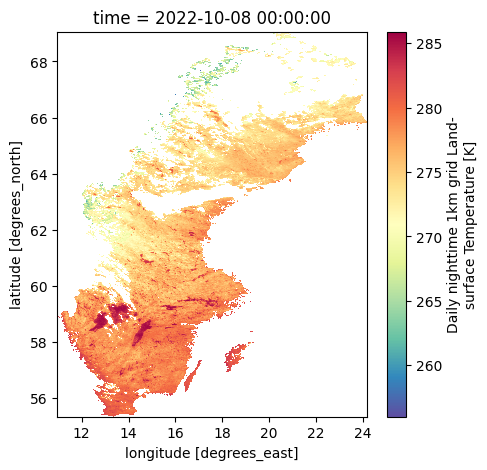

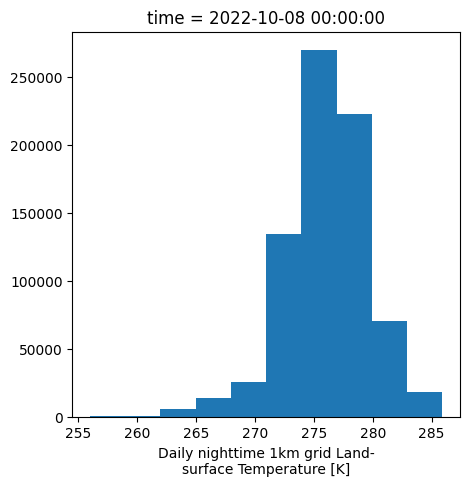

In [7]:
# creating subplot and figure
time = random.randint(0, len(lst_var)) # tale time slice from
f['LST_Night_1km'][time].plot(cmap='Spectral_r', figsize=(5,5));
f['LST_Night_1km'][time].plot.hist(figsize=(5,5));
plt.show()
plt.close()

## 2 GIS Functions f(x)

In [94]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 4 coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def wktDisplay(polygon):
    # Create plot object just like standard WKTPlot class
    plot = OpenStreetMapsPlot("Open Street Map Plot", 
                              height=600,
                              width=600,
                              disable_mercator=False)
    plot.add_shape(polygon, fill_alpha=0.5, fill_color="firebrick")
    plot.show()
    
def GetExtent(ds):
    """ Return list of corner coordinates from a gdal Dataset """
    xmin, xpixel, _, ymax, _, ypixel = ds.GetGeoTransform()
    width, height = ds.RasterXSize, ds.RasterYSize
    xmax = xmin + width * xpixel
    ymin = ymax + height * ypixel
    extent_dict = {
      'lons_width': width, 
      'lats_height': height, 
      'xpixel': xpixel, 
      'ypixel': ypixel,
      'Upper_Left':[xmin, ymax],
      'Bottom_Left':[xmin, ymin],
      'Upper_Right':[xmax, ymax],
      'Bottom_Right':[xmax, ymin]        
    }
    return extent_dict
    #return (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin), (xpixel, ypixel), (width, height)
   
def geo2grid(lons, lats, upper_left_lon_x, upper_left_lat_y, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(upper_left_lon_x, pixel_size, xskew, upper_left_lat_y, 0.0, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    #float to int (more than 1 val)
#     if flag == 0:
#         xs = np.round(xs).astype(np.int64)
#         ys = np.round(ys).astype(np.int64)
#     else:
    xs = np.int64(xs)
    ys = np.int64(ys)
    print(xs)
    print(ys)
    return xs, ys 

def add_closing_coordinates(d):
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def geoPOLYGON_to_gridPOLYGON(polygon_str):
    data = polygon_str
    data_wkt = add_closing_coordinates(data)
    polygon = wkt.loads(data_wkt)
    coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
    expected_list_of_coordinates_for_received_code = [{"lat": x, "long": y} for x, y in coords]
    lat_arr = []
    long_arr = []
    for i in range(len(expected_list_of_coordinates_for_received_code)):
        long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['lat'])
        lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['long'])
    
    long_list = long_arr.tolist()
    lat_list = lat_arr.tolist()
    
    return long_list, lat_list

## 3. Prerequisites

In [9]:
upper_left_lon_x = GetExtent(rds)['Upper_Left'][0] # should be fetched from xr.dataset or gdal dataset rds
upper_left_lat_y = GetExtent(rds)['Upper_Left'][1] # should be fetched from xr.dataset
pixel_size = GetExtent(rds)['xpixel'] # should be fetched from xr.dataset

## 4. Translate Geo to Grid

### 4.1 Test Cases

In [10]:
origin_lon = upper_left_lon_x
origin_lat = upper_left_lat_y

center_lon = 17.5666667
center_lat = 62.2000000

target_lon = 15.7875
target_lat = 63.95417

test_lons = [10.9625, 19.0875, 11.0125, 10.97083]
test_lats = [69.0625, 65.1375, 68.90417, 69.05417]

panoply_lons = [15.7375, 15.74583, 15.75417, 15.7625]
panoply_lats = [63.89853, 63.8875, 63.87917, 63.87083]

# lons_ume = [21.012500762939453, 21.012500762939453, 19.757331162882714, 19.757331162882714]
# lats_ume = [63.54158456667918, 64.380134753, 64.380134753, 63.54158456667918]

In [11]:
x_grid, y_grid = geo2grid(origin_lon,
                          origin_lat,
                          upper_left_lon_x,
                          upper_left_lat_y,
                          pixel_size)

0
0


In [12]:
time = 0
pixel_val = lst_var[time, x_grid, y_grid]
pixel_val

nan

### 4.2 Validation

In [97]:
x_grid, y_grid = geo2grid(panoply_lons,
                          panoply_lats,
                          upper_left_lon_x,
                          upper_left_lat_y,
                          pixel_size)

[573 574 575 576]
[620 621 622 623]


In [14]:
time = 0
pixel_val = lst_var[time, x_grid, y_grid]
pixel_val

array([nan, nan, nan, nan])

# PostgreSQL Entry Point 
## Case 1: Linköping 
### INPUT = `geom` data fetched from relational table in `POLYGON` WKT format
### OUTPUT =  correspoding positional `array indices` in `POLYGON` WKT format of the `geom`

as RasQL only accepts array grid indices for clipping data, hence the `OUTPUT`

In [28]:
# geom_from_postgres = str(POLYGON((15.283931732177846 58.128513336181754,15.2924165725708 58.12883377075198,15.30090236663824 58.129150390625114,15.300308227539062 58.133628845214844,15.308794975280762 58.13394927978527,15.317282676696777 58.134262084960994,15.325770378112793 58.1345787048341,15.334258079528807 58.134895324707145,15.33366680145275 58.139373779296875,15.333074569702148 58.143856048583984,15.34156417846674 58.14416885375971,15.340973854064941 58.14865112304682,15.349466323852653 58.14896392822271,15.348875999450627 58.153446197509794,15.35736846923834 58.153759002685575,15.365859985351676 58.15407180786144,15.365274429321346 58.15855026245123,15.373768806457633 58.158863067626896,15.382261276245117 58.15917587280279,15.38167476654047 58.1636581420899,15.37318134307867 58.163345336914006,15.37259483337408 58.16782379150396,15.372007369995176 58.17230606079107,15.371418952941953 58.1767845153808,15.379918098449648 58.1770973205567,15.379331588745233 58.18157958984378,15.378744125366325 58.186058044433594,15.378157615661678 58.190540313720675,15.377573013305664 58.195018768310604,15.376983642578125 58.19950103759771,15.37639904022228 58.2039794921875,15.375810623169057 58.2084579467774,15.375223159790153 58.21294021606451,15.366717338561955 58.212627410888786,15.366128921508789 58.21710586547857,15.365538597106934 58.22158813476568,15.364951133728027 58.226066589355554,15.36435985565191 58.23054885864269,15.363772392273006 58.23502731323242,15.37228488922125 58.235340118408146,15.37169456481945 58.239822387695256,15.371107101440487 58.24430084228521,15.37051868438732 58.24878311157232,15.369928359985295 58.25326156616205,15.369339942932072 58.25774002075201,15.360822677612418 58.257427215576286,15.360231399536131 58.26190948486337,15.359640121460018 58.266387939453125,15.35112094879156 58.2660751342774,15.350530624389762 58.27055358886719,15.34993839263916 58.2750358581543,15.349345207214299 58.2795143127442,15.340824127197266 58.2792015075683,15.340229034423773 58.28367996215826,15.339635848999079 58.28816223144537,15.348162651062127 58.288475036621094,15.347567558288631 58.29295349121102,15.346975326538086 58.297435760498104,15.346383094787654 58.301914215087834,15.354910850524961 58.30223083496094,15.354317665100098 58.30670928955081,15.353726387023983 58.3111877441406,15.362257003784181 58.31150436401367,15.361665725708063 58.31598281860363,15.361074447631836 58.32046127319336,15.360481262207147 58.32494354248047,15.36901664733898 58.325256347656364,15.368426322936957 58.32973480224618,15.36783409118658 58.33421707153326,15.367242813110467 58.33869552612316,15.366650581359918 58.34317779541027,15.358113288879451 58.3428649902344,15.34957599639904 58.34254837036133,15.341037750244142 58.342235565185604,15.332500457763727 58.34191894531253,15.331905364990291 58.34640121459961,15.340442657470703 58.346714019775504,15.339847564697209 58.351196289062614,15.34838771820074 58.35150909423834,15.347796440124624 58.35598754882807,15.347201347351188 58.36046981811518,15.346606254577695 58.364948272705135,15.346011161804256 58.369430541992244,15.3545560836792 58.36974334716797,15.353962898254508 58.37422180175787,15.353367805481072 58.37870407104501,15.352775573730467 58.383182525634766,15.35218143463135 58.387664794921875,15.34363174438488 58.38734817504874,15.343036651611444 58.39183044433585,15.334487915039118 58.391513824462976,15.325936317443904 58.3911972045899,15.317390441894645 58.39088058471688,15.308837890624945 58.39056396484375,15.309437751770078 58.38608551025402,15.300890922546502 58.385768890380916,15.292344093322754 58.38545227050787,15.283795356750431 58.385131835937614,15.283190727233888 58.389610290527344,15.274643898010309 58.389293670654325,15.266095161437988 58.38897323608404,15.26548862457281 58.39345169067377,15.264883041381948 58.39793395996091,15.264279365539666 58.40241241455084,15.272828102111761 58.402732849121094,15.272226333618278 58.407211303710966,15.28077983856207 58.40753173828128,15.289331436157283 58.407848358154354,15.297884941101074 58.40816879272458,15.297283172607536 58.41264724731448,15.305836677551328 58.412963867187614,15.30523681640625 58.417442321777344,15.304636001586973 58.42192459106445,15.313194274902457 58.42224121093756,15.312594413757326 58.42671966552746,15.311992645263615 58.43120193481457,15.320550918579102 58.43151473999029,15.319953918457033 58.4359970092774,15.319352149963324 58.44047546386713,15.327915191650446 58.44079208374026,15.336477279663086 58.44110870361328,15.345038414001579 58.441421508789006,15.344443321228143 58.445903778076115,15.353006362915039 58.44621658325204,15.361568450927848 58.446529388427734,15.36097431182867 58.451011657714844,15.360379219055234 58.45549011230477,15.36894607543951 58.45580291748044,15.377511024475213 58.45611572265622,15.386075973510742 58.45642852783209,15.394640922546444 58.45674133300781,15.394050598144643 58.46121978759777,15.393460273742619 58.46570205688488,15.384893417358343 58.465389251708984,15.376325607299748 58.46507644653326,15.367758750915469 58.464763641357536,15.367163658142204 58.469242095947266,15.375733375549373 58.46955490112299,15.384301185607967 58.46986770629891,15.383709907531854 58.47434997558602,15.375138282775938 58.4740371704101,15.374546051025332 58.47851562500003,15.373952865600643 58.482997894287166,15.373360633850098 58.48747634887707,15.372765541076605 58.491958618164176,15.372173309326229 58.49643707275396,15.371578216552793 58.500915527343864,15.370984077453612 58.50539779663097,15.379562377929801 58.5057106018067,15.378967285156305 58.5101890563964,15.37837505340576 58.51467132568351,15.377779960632267 58.519149780273494,15.377186775207578 58.523628234863224,15.385770797729549 58.52394104003912,15.38517570495611 58.5284233093262,15.38458347320551 58.53290176391599,15.383991241455133 58.537380218505945,15.383398056030273 58.541862487793026,15.374810218811149 58.5415496826173,15.374215126037656 58.54602813720709,15.382802963256777 58.546340942382756,15.382210731506406 58.550823211669865,15.381615638732967 58.55530166625982,15.381020545959473 58.55978012084955,15.380428314209098 58.56426239013666,15.379833221435602 58.56874084472662,15.388425827026424 58.569053649902344,15.38783264160156 58.57353591918945,15.387237548828068 58.578014373779354,15.378645896911621 58.57770156860343,15.378048896789553 58.58218383789057,15.377453804016113 58.586662292480526,15.386051177978516 58.58697509765625,15.385456085205078 58.59145355224612,15.384862899780385 58.59593582153326,15.393463134765682 58.596244812011804,15.392868041992243 58.600727081298885,15.392274856567383 58.60520553588867,15.383673667907772 58.60489273071295,15.38307857513428 58.60937500000006,15.382484436035158 58.61385345458979,15.373880386352655 58.61354064941409,15.373283386230582 58.61802291870117,15.381889343261662 58.618335723876896,15.381292343139648 58.622814178466854,15.380697250366152 58.627292633056584,15.389305114746207 58.62760543823251,15.38871097564703 58.63208770751962,15.397318840026912 58.63239669799816,15.396725654602053 58.63687896728527,15.405337333679256 58.63718795776376,15.404742240905817 58.641670227050895,15.413354873657283 58.64197921752927,15.421965599060059 58.64228820800781,15.430578231811582 58.6425971984863,15.431168556213377 58.63811874389657,15.439779281616323 58.638427734375114,15.44036674499523 58.633945465088004,15.448978424072266 58.63425445556638,15.44956588745117 58.62977600097665,15.458171844482479 58.63008117675781,15.458758354187069 58.625602722168026,15.467368125915527 58.62590789794922,15.467951774597282 58.62142944335949,15.476557731628532 58.621734619140625,15.47597599029541 58.62621307373058,15.484581947326658 58.626518249511776,15.493190765380803 58.62682342529291,15.50180053710943 58.627128601074276,15.510410308837892 58.62743377685547,15.50983142852783 58.63191223144537,15.518441200256461 58.63221740722659,15.527051925659178 58.632518768310575,15.535659790039064 58.63282012939459,15.544271469116268 58.633125305175724,15.544844627380428 58.628643035888615,15.536236763000545 58.62834167480463,15.536810874938967 58.62385940551752,15.537387847900504 58.61938095092779,15.537961959838926 58.61489868164071,15.538538932800407 58.6104164123536,15.529934883117734 58.61011505126959,15.530507087707576 58.60563659667977,15.53108406066906 58.60115432739269,15.531662940979006 58.59667205810558,15.54026222228998 58.596977233886776,15.548863410949822 58.59727859497076,15.548291206359977 58.60175704956055,15.556893348693848 58.60205841064453,15.565496444702262 58.602359771728516,15.564924240112418 58.60683822631847,15.573530197143498 58.60713958740246,15.572956085205076 58.61162185668957,15.572387695312614 58.6161003112793,15.580993652343864 58.61640167236331,15.580425262451172 58.62088012695324,15.579854965209961 58.62536239624035,15.579284667968865 58.62984466552746,15.587892532348746 58.63014221191412,15.588462829589785 58.62565994262701,15.597071647644155 58.625957489013615,15.605682373046875 58.626255035400476,15.606249809265252 58.62177658081046,15.60681533813488 58.61729431152338,15.615423202514705 58.61759185791021,15.615987777710018 58.613109588623075,15.616551399231012 58.608627319335994,15.617116928100643 58.604148864746094,15.617682456970215 58.599666595458984,15.626284599304315 58.59996032714844,15.625720024108828 58.60444259643555,15.634325981140137 58.60474014282238,15.64293003082281 58.60503387451183,15.643490791320914 58.60055160522475,15.652093887329102 58.600845336914176,15.652654647827262 58.59636688232422,15.653212547302301 58.59188461303708,15.653774261474723 58.58740234375,15.654335021972656 58.58292007446289,15.662934303283693 58.583213806152344,15.663492202758789 58.578731536865234,15.664048194885256 58.574253082275504,15.672648429870549 58.574542999267635,15.673204421997012 58.57006454467785,15.681800842285156 58.57035446166998,15.690395355224725 58.57064819335946,15.690951347351017 58.56616592407232,15.691505432128908 58.56168365478521,15.692058563232479 58.557201385498104,15.692612648010366 58.552722930908146,15.701205253601188 58.55301284790045,15.701757431030272 58.54853057861334,15.710349082946776 58.54882049560541,15.718938827514647 58.54911041259771,15.7194881439209 58.544628143310604,15.728080749511662 58.544918060302734,15.736671447753848 58.54520797729495,15.74526119232178 58.54549407958993,15.75385093688965 58.54578018188482,15.762442588806154 58.54607009887695,15.762988090515194 58.541587829589844,15.763532638549806 58.537105560302706,15.764075279235955 58.532623291015625,15.764619827270508 58.528141021728516,15.765165328979547 58.523658752441406,15.765708923339842 58.5191764831543,15.766251564025822 58.51469421386719,15.766796112060604 58.51021194458008,15.767338752746582 58.50572967529294,15.775919914245664 58.50601577758792,15.784502983093319 58.50630187988281,15.793084144592342 58.506587982177734,15.801665306091424 58.50687026977545,15.801124572753851 58.51135253906256,15.809707641601506 58.51163864135748,15.818290710449162 58.51192092895508,15.826873779296816 58.51220321655276,15.835457801818961 58.512485504150334,15.84404087066662 58.512763977050696,15.84457397460949 58.508281707763615,15.853155136108342 58.50856399536141,15.861736297607424 58.508842468261804,15.862269401550295 58.504360198974695,15.870849609375057 58.50464248657238,15.870319366455078 58.50912475585949,15.878903388977049 58.50940322875988,15.887486457824707 58.50968170166027,15.896068572998047 58.50995635986328,15.89659309387207 58.5054740905762,15.905176162719725 58.50575256347659,15.913760185241701 58.50603103637695,15.922341346740723 58.506305694580135,15.922864913940485 58.501823425293054,15.92338657379162 58.497341156005945,15.931967735290527 58.497615814208984,15.93249034881592 58.49313354492185,15.933009147643986 58.488651275634766,15.933532714843748 58.48416519165045,15.924957275390627 58.483890533447266,15.916380882263182 58.4836158752442,15.907803535461483 58.483341217041016,15.908329010009822 58.478858947753906,15.90885257720953 58.474372863769645,15.917428970336971 58.47465133666998,15.917950630188102 58.4701690673829,15.926525115966912 58.47044372558594,15.92704677581787 58.46596145629883,15.935619354248104 58.46623611450201,15.944192886352653 58.46651077270502,15.944712638855037 58.46202850341788,15.953282356262209 58.46230316162118,15.961853981018121 58.46257400512695,15.962373733520506 58.458091735839844,15.962890625 58.453609466552734,15.963408470153924 58.449127197265625,15.971976280212514 58.449398040771484,15.972493171692008 58.444915771484375,15.973008155822695 58.440433502197266,15.973523139953613 58.435951232910156,15.964958190918082 58.435676574707145,15.965477943420467 58.431194305420036,15.956912994384767 58.430923461914176,15.95742797851568 58.42643737792977,15.95794773101801 58.421955108642635,15.966507911682244 58.42222976684582,15.967024803161735 58.41774749755871,15.975585937500059 58.41801834106454,15.984146118164121 58.41828918457037,15.992709159851017 58.41856002807623,16.001268386840763 58.41883087158209,16.001781463623104 58.41434860229498,16.010343551635742 58.41461944580084,16.01085090637207 58.41013717651373,16.01136016845703 58.40565109252941,16.011873245239315 58.4011688232423,16.020429611205998 58.40143966674816,16.028987884521484 58.40170669555661,16.037544250488338 58.4019775390625,16.038051605224666 58.39749145507815,16.038555145263672 58.393009185791044,16.039064407348633 58.38852691650396,16.04761886596691 58.38879394531244,16.048124313354492 58.384311676025334,16.048629760742244 58.37982559204107,16.057180404663143 58.38009262084972,16.05768585205078 58.375610351562614,16.058189392089957 58.37112808227553,16.066740036010856 58.371395111083984,16.06724166870123 58.36690902709972,16.058692932128906 58.366641998291044,16.050142288208008 58.366378784179744,16.04159545898449 58.366111755371094,16.04210090637207 58.361625671386776,16.033550262451115 58.3613586425781,16.025003433227596 58.361091613769645,16.025512695312557 58.356605529785156,16.016967773437557 58.35633850097665,16.00842094421381 58.356067657470646,16.007911682128906 58.360553741455135,15.999363899231014 58.36028289794925,15.999875068664553 58.355800628662166,16.000385284423828 58.35131454467768,15.991841316223145 58.351043701171875,15.983296394348201 58.350772857666016,15.983809471130487 58.346290588378906,15.975263595581055 58.34601974487305,15.966721534728947 58.34574890136719,15.95817756652832 58.345474243164176,15.958695411682072 58.34099197387707,15.959210395812988 58.33650970458996,15.967752456665039 58.33678054809582,15.968264579773063 58.33229827880871,15.95972537994385 58.33202743530288,15.951185226440373 58.331752777099695,15.94264793395996 58.3314781188964,15.943162918090877 58.32699584960932,15.934624671936147 58.32672119140628,15.934107780456657 58.33120346069339,15.925567626953182 58.330928802490206,15.925045967101996 58.335411071777344,15.91650581359869 58.33513641357433,15.907965660095215 58.334861755371094,15.907442092895508 58.33934402465823,15.898901939392202 58.33906555175781,15.899426460266227 58.3345832824707,15.899950027465934 58.330101013183594,15.89140987396246 58.3298225402832,15.891935348510742 58.325340270996094,15.883397102356014 58.32506179809576,15.874858856201115 58.32478332519537,15.866321563720703 58.32450485229498,15.85778427124029 58.32422637939459,15.858312606811467 58.31974411010748,15.849778175354118 58.31946182250968,15.841239929199219 58.319183349609375,15.841771125793514 58.314701080322266,15.833237648010256 58.31441879272464,15.83376884460449 58.30993652343756,15.825233459472656 58.309654235839844,15.825766563415527 58.305171966552734,15.817234039306754 58.304889678955135,15.816699981689455 58.309371948242244,15.80816745758068 58.30908966064453,15.808700561523496 58.30460739135742,15.80923557281494 58.30012512207034,15.809769630432129 58.2956428527832,15.810302734375002 58.291160583496065,15.818831443786735 58.291442871093835,15.819364547729606 58.2869606018067,15.810837745666618 58.286678314208984,15.811371803283748 58.282196044921875,15.802843093872184 58.281913757324276,15.80337905883789 58.277431488037166,15.811902999878043 58.277713775634766,15.812436103820858 58.273231506347656,15.820961952209588 58.27351379394537,15.821493148803654 58.26903152465826,15.830017089843807 58.26931381225586,15.830548286438045 58.26483154296875,15.831078529358026 58.26034927368164,15.839600563049373 58.26063156127938,15.840129852294865 58.256149291992244,15.831610679626579 58.2558670043945,15.832139015197809 58.25138473510742,15.832670211792049 58.24690246582031,15.824151039123592 58.24662017822271,15.824684143066463 58.242137908935604,15.825215339660701 58.237655639648494,15.825745582580678 58.233173370361385,15.834259033203184 58.233455657958984,15.834790229797477 58.228973388671875,15.835318565368652 58.22449111938474,15.843833923339956 58.224769592285156,15.844360351562557 58.22028732299802,15.835849761962947 58.220008850097656,15.836378097534123 58.21552276611334,15.83690738677984 58.21104049682623,15.837435722351017 58.20655822753912,15.828927993774473 58.20627975463873,15.829457283020135 58.20179748535162,15.8209486007691 58.201515197753906,15.812440872192326 58.20123291015631,15.803935050964355 58.20094680786141,15.79542732238781 58.20066452026364,15.795960426330682 58.19618225097656,15.787454605102482 58.19589614868164,15.778948783874513 58.1956138610841,15.770442962646541 58.195327758789176,15.770980834961051 58.19084548950207,15.762476921081486 58.190559387207145,15.763014793395994 58.186077117920036,15.754511833190916 58.185791015625114,15.755049705505428 58.181308746337976,15.746548652648926 58.18102264404308,15.73804473876953 58.18073272705078,15.737504959106445 58.18521499633789,15.729001998901367 58.18492889404297,15.720498085021973 58.18463897705084,15.719956398010252 58.18912124633795,15.711451530456602 58.1888313293457,15.711998939514217 58.184349060058594,15.703495979309139 58.18405914306646,15.704039573669434 58.179576873779354,15.712541580200194 58.179866790771484,15.713084220886174 58.175384521484375,15.713628768920955 58.17090225219724,15.714173316955511 58.16642379760745,15.71471595764166 58.16194152832037,15.706218719482537 58.161651611328125,15.69772338867199 58.161361694335994,15.689226150512638 58.16106796264654,15.689772605895996 58.15658950805664,15.681276321411131 58.15629577636719,15.672781944274902 58.15600585937503,15.66428470611578 58.155712127685604,15.655791282653809 58.15541839599615,15.655240058898983 58.15990066528326,15.65468788146967 58.16438293457037,15.654136657714844 58.16886520385748,15.65358734130865 58.17334365844718,15.645088195800895 58.173049926757926,15.644535064697322 58.177532196045064,15.636033058166504 58.17723846435558,15.627533912658803 58.1769447326661,15.626977920532283 58.18142318725586,15.618476867675783 58.181129455566406,15.60997581481928 58.1808319091798,15.60147666931158 58.18053436279297,15.592975616455078 58.18023681640631,15.59241771697998 58.184719085693445,15.583913803100643 58.184421539306584,15.57541275024414 58.18412399291998,15.57485198974615 58.18860626220706,15.574289321899471 58.19308471679679,15.565786361694336 58.19278717041021,15.557282447815 58.19248580932617,15.557849884033146 58.18800735473644,15.558410644531307 58.18352508544933,15.558973312377987 58.17904281616222,15.559538841247614 58.174560546875114,15.560102462768612 58.170082092285156,15.560665130615348 58.16559982299805,15.561227798461855 58.16111755371094,15.552730560302733 58.16082000732433,15.553296089172306 58.15633773803722,15.553858757019043 58.151855468750114,15.554422378540039 58.147377014160185,15.554985046386776 58.14289474487305,15.555547714233455 58.13841247558594,15.556113243103086 58.13393020629883,15.547622680664176 58.13363265991222,15.548186302185002 58.129150390625114,15.539698600768986 58.12884902954107,15.540264129638787 58.124366760253935,15.53177738189703 58.12406539916998,15.532341957092342 58.11958694458008,15.523857116699219 58.119281768798885,15.524423599243109 58.114803314208956,15.515938758850154 58.114501953124915,15.516506195068358 58.110019683837834,15.517073631286735 58.105537414550724,15.508592605590763 58.10523605346691,15.509160995483455 58.1007537841798,15.517643928527834 58.101058959960994,15.518209457397575 58.096576690673885,15.518775939941463 58.092094421386776,15.519342422485353 58.08761596679685,15.519908905029295 58.08313369750971,15.511432647705135 58.082828521728544,15.512000083923338 58.07835006713876,15.503523826599233 58.07804489135742,15.495051383972282 58.07774353027344,15.495617866516172 58.07326126098636,15.487144470214957 58.072956085205135,15.487713813781738 58.068477630615234,15.479242324829102 58.06817245483404,15.470768928527832 58.067863464355526,15.471341133117676 58.0633850097656,15.462868690490781 58.063079833984375,15.462297439575195 58.06755828857433,15.453823089599666 58.06725311279297,15.453248977661246 58.0717315673829,15.452674865722656 58.076213836670036,15.461148262024038 58.0765190124512,15.460574150085447 58.08100128173828,15.45209980010992 58.080696105957145,15.44362354278559 58.08038711547857,15.435148239135799 58.08007812500006,15.435725212097282 58.0755996704101,15.43630123138428 58.07111740112299,15.436880111694393 58.06663894653326,15.428405761718865 58.066329956054744,15.42898464202875 58.061847686767635,15.4205141067506 58.06153869628906,15.42109298706049 58.05706024169933,15.412623405456658 58.05675125122079,15.404151916503961 58.056438446044865,15.395683288574219 58.05612945556652,15.387212753295897 58.055816650390625,15.378744125366325 58.05550765991208,15.378161430358832 58.05998611450201,15.377576828002987 58.06446838378912,15.37699413299572 58.068946838378906,15.385464668273926 58.0692596435548,15.384881973266658 58.07373809814453,15.37640762329113 58.073429107666016,15.36793422698986 58.07311630249032,15.359461784362736 58.07280349731454,15.358874320984 58.07728195190427,15.350400924682617 58.07696914672857,15.349813461303654 58.08144760131836,15.349225044250488 58.08592987060547,15.348636627197266 58.09040832519537,15.348049163818304 58.09489059448251,15.339570045471135 58.09457397460943,15.331091880798454 58.09426116943371,15.322615623474121 58.09394454956063,15.31413745880127 58.09362792968756,15.313545227050838 58.09810638427729,15.305064201355094 58.09778976440441,15.296587944030763 58.09747314453131,15.295990943908746 58.101955413818416,15.295395851135254 58.1064338684082,15.294800758361815 58.110912322998104,15.286319732666072 58.11059570312506,15.285722732544 58.11507415771479,15.285125732421932 58.119556427001896,15.284528732299918 58.124034881591854,15.283931732177846 58.128513336181754)))

# # INPUT = "'" + str(POLYGON((15.283931732177846 58.128513336181754,15.2924165725708 58.12883377075198,15.30090236663824 58.129150390625114,15.300308227539062 58.133628845214844,15.308794975280762 58.13394927978527,15.317282676696777 58.134262084960994,15.325770378112793 58.1345787048341,15.334258079528807 58.134895324707145,15.33366680145275 58.139373779296875,15.333074569702148 58.143856048583984,15.34156417846674 58.14416885375971,15.340973854064941 58.14865112304682,15.349466323852653 58.14896392822271,15.348875999450627 58.153446197509794,15.35736846923834 58.153759002685575,15.365859985351676 58.15407180786144,15.365274429321346 58.15855026245123,15.373768806457633 58.158863067626896,15.382261276245117 58.15917587280279,15.38167476654047 58.1636581420899,15.37318134307867 58.163345336914006,15.37259483337408 58.16782379150396,15.372007369995176 58.17230606079107,15.371418952941953 58.1767845153808,15.379918098449648 58.1770973205567,15.379331588745233 58.18157958984378,15.378744125366325 58.186058044433594,15.378157615661678 58.190540313720675,15.377573013305664 58.195018768310604,15.376983642578125 58.19950103759771,15.37639904022228 58.2039794921875,15.375810623169057 58.2084579467774,15.375223159790153 58.21294021606451,15.366717338561955 58.212627410888786,15.366128921508789 58.21710586547857,15.365538597106934 58.22158813476568,15.364951133728027 58.226066589355554,15.36435985565191 58.23054885864269,15.363772392273006 58.23502731323242,15.37228488922125 58.235340118408146,15.37169456481945 58.239822387695256,15.371107101440487 58.24430084228521,15.37051868438732 58.24878311157232,15.369928359985295 58.25326156616205,15.369339942932072 58.25774002075201,15.360822677612418 58.257427215576286,15.360231399536131 58.26190948486337,15.359640121460018 58.266387939453125,15.35112094879156 58.2660751342774,15.350530624389762 58.27055358886719,15.34993839263916 58.2750358581543,15.349345207214299 58.2795143127442,15.340824127197266 58.2792015075683,15.340229034423773 58.28367996215826,15.339635848999079 58.28816223144537,15.348162651062127 58.288475036621094,15.347567558288631 58.29295349121102,15.346975326538086 58.297435760498104,15.346383094787654 58.301914215087834,15.354910850524961 58.30223083496094,15.354317665100098 58.30670928955081,15.353726387023983 58.3111877441406,15.362257003784181 58.31150436401367,15.361665725708063 58.31598281860363,15.361074447631836 58.32046127319336,15.360481262207147 58.32494354248047,15.36901664733898 58.325256347656364,15.368426322936957 58.32973480224618,15.36783409118658 58.33421707153326,15.367242813110467 58.33869552612316,15.366650581359918 58.34317779541027,15.358113288879451 58.3428649902344,15.34957599639904 58.34254837036133,15.341037750244142 58.342235565185604,15.332500457763727 58.34191894531253,15.331905364990291 58.34640121459961,15.340442657470703 58.346714019775504,15.339847564697209 58.351196289062614,15.34838771820074 58.35150909423834,15.347796440124624 58.35598754882807,15.347201347351188 58.36046981811518,15.346606254577695 58.364948272705135,15.346011161804256 58.369430541992244,15.3545560836792 58.36974334716797,15.353962898254508 58.37422180175787,15.353367805481072 58.37870407104501,15.352775573730467 58.383182525634766,15.35218143463135 58.387664794921875,15.34363174438488 58.38734817504874,15.343036651611444 58.39183044433585,15.334487915039118 58.391513824462976,15.325936317443904 58.3911972045899,15.317390441894645 58.39088058471688,15.308837890624945 58.39056396484375,15.309437751770078 58.38608551025402,15.300890922546502 58.385768890380916,15.292344093322754 58.38545227050787,15.283795356750431 58.385131835937614,15.283190727233888 58.389610290527344,15.274643898010309 58.389293670654325,15.266095161437988 58.38897323608404,15.26548862457281 58.39345169067377,15.264883041381948 58.39793395996091,15.264279365539666 58.40241241455084,15.272828102111761 58.402732849121094,15.272226333618278 58.407211303710966,15.28077983856207 58.40753173828128,15.289331436157283 58.407848358154354,15.297884941101074 58.40816879272458,15.297283172607536 58.41264724731448,15.305836677551328 58.412963867187614,15.30523681640625 58.417442321777344,15.304636001586973 58.42192459106445,15.313194274902457 58.42224121093756,15.312594413757326 58.42671966552746,15.311992645263615 58.43120193481457,15.320550918579102 58.43151473999029,15.319953918457033 58.4359970092774,15.319352149963324 58.44047546386713,15.327915191650446 58.44079208374026,15.336477279663086 58.44110870361328,15.345038414001579 58.441421508789006,15.344443321228143 58.445903778076115,15.353006362915039 58.44621658325204,15.361568450927848 58.446529388427734,15.36097431182867 58.451011657714844,15.360379219055234 58.45549011230477,15.36894607543951 58.45580291748044,15.377511024475213 58.45611572265622,15.386075973510742 58.45642852783209,15.394640922546444 58.45674133300781,15.394050598144643 58.46121978759777,15.393460273742619 58.46570205688488,15.384893417358343 58.465389251708984,15.376325607299748 58.46507644653326,15.367758750915469 58.464763641357536,15.367163658142204 58.469242095947266,15.375733375549373 58.46955490112299,15.384301185607967 58.46986770629891,15.383709907531854 58.47434997558602,15.375138282775938 58.4740371704101,15.374546051025332 58.47851562500003,15.373952865600643 58.482997894287166,15.373360633850098 58.48747634887707,15.372765541076605 58.491958618164176,15.372173309326229 58.49643707275396,15.371578216552793 58.500915527343864,15.370984077453612 58.50539779663097,15.379562377929801 58.5057106018067,15.378967285156305 58.5101890563964,15.37837505340576 58.51467132568351,15.377779960632267 58.519149780273494,15.377186775207578 58.523628234863224,15.385770797729549 58.52394104003912,15.38517570495611 58.5284233093262,15.38458347320551 58.53290176391599,15.383991241455133 58.537380218505945,15.383398056030273 58.541862487793026,15.374810218811149 58.5415496826173,15.374215126037656 58.54602813720709,15.382802963256777 58.546340942382756,15.382210731506406 58.550823211669865,15.381615638732967 58.55530166625982,15.381020545959473 58.55978012084955,15.380428314209098 58.56426239013666,15.379833221435602 58.56874084472662,15.388425827026424 58.569053649902344,15.38783264160156 58.57353591918945,15.387237548828068 58.578014373779354,15.378645896911621 58.57770156860343,15.378048896789553 58.58218383789057,15.377453804016113 58.586662292480526,15.386051177978516 58.58697509765625,15.385456085205078 58.59145355224612,15.384862899780385 58.59593582153326,15.393463134765682 58.596244812011804,15.392868041992243 58.600727081298885,15.392274856567383 58.60520553588867,15.383673667907772 58.60489273071295,15.38307857513428 58.60937500000006,15.382484436035158 58.61385345458979,15.373880386352655 58.61354064941409,15.373283386230582 58.61802291870117,15.381889343261662 58.618335723876896,15.381292343139648 58.622814178466854,15.380697250366152 58.627292633056584,15.389305114746207 58.62760543823251,15.38871097564703 58.63208770751962,15.397318840026912 58.63239669799816,15.396725654602053 58.63687896728527,15.405337333679256 58.63718795776376,15.404742240905817 58.641670227050895,15.413354873657283 58.64197921752927,15.421965599060059 58.64228820800781,15.430578231811582 58.6425971984863,15.431168556213377 58.63811874389657,15.439779281616323 58.638427734375114,15.44036674499523 58.633945465088004,15.448978424072266 58.63425445556638,15.44956588745117 58.62977600097665,15.458171844482479 58.63008117675781,15.458758354187069 58.625602722168026,15.467368125915527 58.62590789794922,15.467951774597282 58.62142944335949,15.476557731628532 58.621734619140625,15.47597599029541 58.62621307373058,15.484581947326658 58.626518249511776,15.493190765380803 58.62682342529291,15.50180053710943 58.627128601074276,15.510410308837892 58.62743377685547,15.50983142852783 58.63191223144537,15.518441200256461 58.63221740722659,15.527051925659178 58.632518768310575,15.535659790039064 58.63282012939459,15.544271469116268 58.633125305175724,15.544844627380428 58.628643035888615,15.536236763000545 58.62834167480463,15.536810874938967 58.62385940551752,15.537387847900504 58.61938095092779,15.537961959838926 58.61489868164071,15.538538932800407 58.6104164123536,15.529934883117734 58.61011505126959,15.530507087707576 58.60563659667977,15.53108406066906 58.60115432739269,15.531662940979006 58.59667205810558,15.54026222228998 58.596977233886776,15.548863410949822 58.59727859497076,15.548291206359977 58.60175704956055,15.556893348693848 58.60205841064453,15.565496444702262 58.602359771728516,15.564924240112418 58.60683822631847,15.573530197143498 58.60713958740246,15.572956085205076 58.61162185668957,15.572387695312614 58.6161003112793,15.580993652343864 58.61640167236331,15.580425262451172 58.62088012695324,15.579854965209961 58.62536239624035,15.579284667968865 58.62984466552746,15.587892532348746 58.63014221191412,15.588462829589785 58.62565994262701,15.597071647644155 58.625957489013615,15.605682373046875 58.626255035400476,15.606249809265252 58.62177658081046,15.60681533813488 58.61729431152338,15.615423202514705 58.61759185791021,15.615987777710018 58.613109588623075,15.616551399231012 58.608627319335994,15.617116928100643 58.604148864746094,15.617682456970215 58.599666595458984,15.626284599304315 58.59996032714844,15.625720024108828 58.60444259643555,15.634325981140137 58.60474014282238,15.64293003082281 58.60503387451183,15.643490791320914 58.60055160522475,15.652093887329102 58.600845336914176,15.652654647827262 58.59636688232422,15.653212547302301 58.59188461303708,15.653774261474723 58.58740234375,15.654335021972656 58.58292007446289,15.662934303283693 58.583213806152344,15.663492202758789 58.578731536865234,15.664048194885256 58.574253082275504,15.672648429870549 58.574542999267635,15.673204421997012 58.57006454467785,15.681800842285156 58.57035446166998,15.690395355224725 58.57064819335946,15.690951347351017 58.56616592407232,15.691505432128908 58.56168365478521,15.692058563232479 58.557201385498104,15.692612648010366 58.552722930908146,15.701205253601188 58.55301284790045,15.701757431030272 58.54853057861334,15.710349082946776 58.54882049560541,15.718938827514647 58.54911041259771,15.7194881439209 58.544628143310604,15.728080749511662 58.544918060302734,15.736671447753848 58.54520797729495,15.74526119232178 58.54549407958993,15.75385093688965 58.54578018188482,15.762442588806154 58.54607009887695,15.762988090515194 58.541587829589844,15.763532638549806 58.537105560302706,15.764075279235955 58.532623291015625,15.764619827270508 58.528141021728516,15.765165328979547 58.523658752441406,15.765708923339842 58.5191764831543,15.766251564025822 58.51469421386719,15.766796112060604 58.51021194458008,15.767338752746582 58.50572967529294,15.775919914245664 58.50601577758792,15.784502983093319 58.50630187988281,15.793084144592342 58.506587982177734,15.801665306091424 58.50687026977545,15.801124572753851 58.51135253906256,15.809707641601506 58.51163864135748,15.818290710449162 58.51192092895508,15.826873779296816 58.51220321655276,15.835457801818961 58.512485504150334,15.84404087066662 58.512763977050696,15.84457397460949 58.508281707763615,15.853155136108342 58.50856399536141,15.861736297607424 58.508842468261804,15.862269401550295 58.504360198974695,15.870849609375057 58.50464248657238,15.870319366455078 58.50912475585949,15.878903388977049 58.50940322875988,15.887486457824707 58.50968170166027,15.896068572998047 58.50995635986328,15.89659309387207 58.5054740905762,15.905176162719725 58.50575256347659,15.913760185241701 58.50603103637695,15.922341346740723 58.506305694580135,15.922864913940485 58.501823425293054,15.92338657379162 58.497341156005945,15.931967735290527 58.497615814208984,15.93249034881592 58.49313354492185,15.933009147643986 58.488651275634766,15.933532714843748 58.48416519165045,15.924957275390627 58.483890533447266,15.916380882263182 58.4836158752442,15.907803535461483 58.483341217041016,15.908329010009822 58.478858947753906,15.90885257720953 58.474372863769645,15.917428970336971 58.47465133666998,15.917950630188102 58.4701690673829,15.926525115966912 58.47044372558594,15.92704677581787 58.46596145629883,15.935619354248104 58.46623611450201,15.944192886352653 58.46651077270502,15.944712638855037 58.46202850341788,15.953282356262209 58.46230316162118,15.961853981018121 58.46257400512695,15.962373733520506 58.458091735839844,15.962890625 58.453609466552734,15.963408470153924 58.449127197265625,15.971976280212514 58.449398040771484,15.972493171692008 58.444915771484375,15.973008155822695 58.440433502197266,15.973523139953613 58.435951232910156,15.964958190918082 58.435676574707145,15.965477943420467 58.431194305420036,15.956912994384767 58.430923461914176,15.95742797851568 58.42643737792977,15.95794773101801 58.421955108642635,15.966507911682244 58.42222976684582,15.967024803161735 58.41774749755871,15.975585937500059 58.41801834106454,15.984146118164121 58.41828918457037,15.992709159851017 58.41856002807623,16.001268386840763 58.41883087158209,16.001781463623104 58.41434860229498,16.010343551635742 58.41461944580084,16.01085090637207 58.41013717651373,16.01136016845703 58.40565109252941,16.011873245239315 58.4011688232423,16.020429611205998 58.40143966674816,16.028987884521484 58.40170669555661,16.037544250488338 58.4019775390625,16.038051605224666 58.39749145507815,16.038555145263672 58.393009185791044,16.039064407348633 58.38852691650396,16.04761886596691 58.38879394531244,16.048124313354492 58.384311676025334,16.048629760742244 58.37982559204107,16.057180404663143 58.38009262084972,16.05768585205078 58.375610351562614,16.058189392089957 58.37112808227553,16.066740036010856 58.371395111083984,16.06724166870123 58.36690902709972,16.058692932128906 58.366641998291044,16.050142288208008 58.366378784179744,16.04159545898449 58.366111755371094,16.04210090637207 58.361625671386776,16.033550262451115 58.3613586425781,16.025003433227596 58.361091613769645,16.025512695312557 58.356605529785156,16.016967773437557 58.35633850097665,16.00842094421381 58.356067657470646,16.007911682128906 58.360553741455135,15.999363899231014 58.36028289794925,15.999875068664553 58.355800628662166,16.000385284423828 58.35131454467768,15.991841316223145 58.351043701171875,15.983296394348201 58.350772857666016,15.983809471130487 58.346290588378906,15.975263595581055 58.34601974487305,15.966721534728947 58.34574890136719,15.95817756652832 58.345474243164176,15.958695411682072 58.34099197387707,15.959210395812988 58.33650970458996,15.967752456665039 58.33678054809582,15.968264579773063 58.33229827880871,15.95972537994385 58.33202743530288,15.951185226440373 58.331752777099695,15.94264793395996 58.3314781188964,15.943162918090877 58.32699584960932,15.934624671936147 58.32672119140628,15.934107780456657 58.33120346069339,15.925567626953182 58.330928802490206,15.925045967101996 58.335411071777344,15.91650581359869 58.33513641357433,15.907965660095215 58.334861755371094,15.907442092895508 58.33934402465823,15.898901939392202 58.33906555175781,15.899426460266227 58.3345832824707,15.899950027465934 58.330101013183594,15.89140987396246 58.3298225402832,15.891935348510742 58.325340270996094,15.883397102356014 58.32506179809576,15.874858856201115 58.32478332519537,15.866321563720703 58.32450485229498,15.85778427124029 58.32422637939459,15.858312606811467 58.31974411010748,15.849778175354118 58.31946182250968,15.841239929199219 58.319183349609375,15.841771125793514 58.314701080322266,15.833237648010256 58.31441879272464,15.83376884460449 58.30993652343756,15.825233459472656 58.309654235839844,15.825766563415527 58.305171966552734,15.817234039306754 58.304889678955135,15.816699981689455 58.309371948242244,15.80816745758068 58.30908966064453,15.808700561523496 58.30460739135742,15.80923557281494 58.30012512207034,15.809769630432129 58.2956428527832,15.810302734375002 58.291160583496065,15.818831443786735 58.291442871093835,15.819364547729606 58.2869606018067,15.810837745666618 58.286678314208984,15.811371803283748 58.282196044921875,15.802843093872184 58.281913757324276,15.80337905883789 58.277431488037166,15.811902999878043 58.277713775634766,15.812436103820858 58.273231506347656,15.820961952209588 58.27351379394537,15.821493148803654 58.26903152465826,15.830017089843807 58.26931381225586,15.830548286438045 58.26483154296875,15.831078529358026 58.26034927368164,15.839600563049373 58.26063156127938,15.840129852294865 58.256149291992244,15.831610679626579 58.2558670043945,15.832139015197809 58.25138473510742,15.832670211792049 58.24690246582031,15.824151039123592 58.24662017822271,15.824684143066463 58.242137908935604,15.825215339660701 58.237655639648494,15.825745582580678 58.233173370361385,15.834259033203184 58.233455657958984,15.834790229797477 58.228973388671875,15.835318565368652 58.22449111938474,15.843833923339956 58.224769592285156,15.844360351562557 58.22028732299802,15.835849761962947 58.220008850097656,15.836378097534123 58.21552276611334,15.83690738677984 58.21104049682623,15.837435722351017 58.20655822753912,15.828927993774473 58.20627975463873,15.829457283020135 58.20179748535162,15.8209486007691 58.201515197753906,15.812440872192326 58.20123291015631,15.803935050964355 58.20094680786141,15.79542732238781 58.20066452026364,15.795960426330682 58.19618225097656,15.787454605102482 58.19589614868164,15.778948783874513 58.1956138610841,15.770442962646541 58.195327758789176,15.770980834961051 58.19084548950207,15.762476921081486 58.190559387207145,15.763014793395994 58.186077117920036,15.754511833190916 58.185791015625114,15.755049705505428 58.181308746337976,15.746548652648926 58.18102264404308,15.73804473876953 58.18073272705078,15.737504959106445 58.18521499633789,15.729001998901367 58.18492889404297,15.720498085021973 58.18463897705084,15.719956398010252 58.18912124633795,15.711451530456602 58.1888313293457,15.711998939514217 58.184349060058594,15.703495979309139 58.18405914306646,15.704039573669434 58.179576873779354,15.712541580200194 58.179866790771484,15.713084220886174 58.175384521484375,15.713628768920955 58.17090225219724,15.714173316955511 58.16642379760745,15.71471595764166 58.16194152832037,15.706218719482537 58.161651611328125,15.69772338867199 58.161361694335994,15.689226150512638 58.16106796264654,15.689772605895996 58.15658950805664,15.681276321411131 58.15629577636719,15.672781944274902 58.15600585937503,15.66428470611578 58.155712127685604,15.655791282653809 58.15541839599615,15.655240058898983 58.15990066528326,15.65468788146967 58.16438293457037,15.654136657714844 58.16886520385748,15.65358734130865 58.17334365844718,15.645088195800895 58.173049926757926,15.644535064697322 58.177532196045064,15.636033058166504 58.17723846435558,15.627533912658803 58.1769447326661,15.626977920532283 58.18142318725586,15.618476867675783 58.181129455566406,15.60997581481928 58.1808319091798,15.60147666931158 58.18053436279297,15.592975616455078 58.18023681640631,15.59241771697998 58.184719085693445,15.583913803100643 58.184421539306584,15.57541275024414 58.18412399291998,15.57485198974615 58.18860626220706,15.574289321899471 58.19308471679679,15.565786361694336 58.19278717041021,15.557282447815 58.19248580932617,15.557849884033146 58.18800735473644,15.558410644531307 58.18352508544933,15.558973312377987 58.17904281616222,15.559538841247614 58.174560546875114,15.560102462768612 58.170082092285156,15.560665130615348 58.16559982299805,15.561227798461855 58.16111755371094,15.552730560302733 58.16082000732433,15.553296089172306 58.15633773803722,15.553858757019043 58.151855468750114,15.554422378540039 58.147377014160185,15.554985046386776 58.14289474487305,15.555547714233455 58.13841247558594,15.556113243103086 58.13393020629883,15.547622680664176 58.13363265991222,15.548186302185002 58.129150390625114,15.539698600768986 58.12884902954107,15.540264129638787 58.124366760253935,15.53177738189703 58.12406539916998,15.532341957092342 58.11958694458008,15.523857116699219 58.119281768798885,15.524423599243109 58.114803314208956,15.515938758850154 58.114501953124915,15.516506195068358 58.110019683837834,15.517073631286735 58.105537414550724,15.508592605590763 58.10523605346691,15.509160995483455 58.1007537841798,15.517643928527834 58.101058959960994,15.518209457397575 58.096576690673885,15.518775939941463 58.092094421386776,15.519342422485353 58.08761596679685,15.519908905029295 58.08313369750971,15.511432647705135 58.082828521728544,15.512000083923338 58.07835006713876,15.503523826599233 58.07804489135742,15.495051383972282 58.07774353027344,15.495617866516172 58.07326126098636,15.487144470214957 58.072956085205135,15.487713813781738 58.068477630615234,15.479242324829102 58.06817245483404,15.470768928527832 58.067863464355526,15.471341133117676 58.0633850097656,15.462868690490781 58.063079833984375,15.462297439575195 58.06755828857433,15.453823089599666 58.06725311279297,15.453248977661246 58.0717315673829,15.452674865722656 58.076213836670036,15.461148262024038 58.0765190124512,15.460574150085447 58.08100128173828,15.45209980010992 58.080696105957145,15.44362354278559 58.08038711547857,15.435148239135799 58.08007812500006,15.435725212097282 58.0755996704101,15.43630123138428 58.07111740112299,15.436880111694393 58.06663894653326,15.428405761718865 58.066329956054744,15.42898464202875 58.061847686767635,15.4205141067506 58.06153869628906,15.42109298706049 58.05706024169933,15.412623405456658 58.05675125122079,15.404151916503961 58.056438446044865,15.395683288574219 58.05612945556652,15.387212753295897 58.055816650390625,15.378744125366325 58.05550765991208,15.378161430358832 58.05998611450201,15.377576828002987 58.06446838378912,15.37699413299572 58.068946838378906,15.385464668273926 58.0692596435548,15.384881973266658 58.07373809814453,15.37640762329113 58.073429107666016,15.36793422698986 58.07311630249032,15.359461784362736 58.07280349731454,15.358874320984 58.07728195190427,15.350400924682617 58.07696914672857,15.349813461303654 58.08144760131836,15.349225044250488 58.08592987060547,15.348636627197266 58.09040832519537,15.348049163818304 58.09489059448251,15.339570045471135 58.09457397460943,15.331091880798454 58.09426116943371,15.322615623474121 58.09394454956063,15.31413745880127 58.09362792968756,15.313545227050838 58.09810638427729,15.305064201355094 58.09778976440441,15.296587944030763 58.09747314453131,15.295990943908746 58.101955413818416,15.295395851135254 58.1064338684082,15.294800758361815 58.110912322998104,15.286319732666072 58.11059570312506,15.285722732544 58.11507415771479,15.285125732421932 58.119556427001896,15.284528732299918 58.124034881591854,15.283931732177846 58.128513336181754)))+"'"

In [22]:
# the output_notebook() from bokeh should be on before having this plot in notebook
wktDisplay('POLYGON((15.283931732177846 58.128513336181754,15.2924165725708 58.12883377075198,15.30090236663824 58.129150390625114,15.300308227539062 58.133628845214844,15.308794975280762 58.13394927978527,15.317282676696777 58.134262084960994,15.325770378112793 58.1345787048341,15.334258079528807 58.134895324707145,15.33366680145275 58.139373779296875,15.333074569702148 58.143856048583984,15.34156417846674 58.14416885375971,15.340973854064941 58.14865112304682,15.349466323852653 58.14896392822271,15.348875999450627 58.153446197509794,15.35736846923834 58.153759002685575,15.365859985351676 58.15407180786144,15.365274429321346 58.15855026245123,15.373768806457633 58.158863067626896,15.382261276245117 58.15917587280279,15.38167476654047 58.1636581420899,15.37318134307867 58.163345336914006,15.37259483337408 58.16782379150396,15.372007369995176 58.17230606079107,15.371418952941953 58.1767845153808,15.379918098449648 58.1770973205567,15.379331588745233 58.18157958984378,15.378744125366325 58.186058044433594,15.378157615661678 58.190540313720675,15.377573013305664 58.195018768310604,15.376983642578125 58.19950103759771,15.37639904022228 58.2039794921875,15.375810623169057 58.2084579467774,15.375223159790153 58.21294021606451,15.366717338561955 58.212627410888786,15.366128921508789 58.21710586547857,15.365538597106934 58.22158813476568,15.364951133728027 58.226066589355554,15.36435985565191 58.23054885864269,15.363772392273006 58.23502731323242,15.37228488922125 58.235340118408146,15.37169456481945 58.239822387695256,15.371107101440487 58.24430084228521,15.37051868438732 58.24878311157232,15.369928359985295 58.25326156616205,15.369339942932072 58.25774002075201,15.360822677612418 58.257427215576286,15.360231399536131 58.26190948486337,15.359640121460018 58.266387939453125,15.35112094879156 58.2660751342774,15.350530624389762 58.27055358886719,15.34993839263916 58.2750358581543,15.349345207214299 58.2795143127442,15.340824127197266 58.2792015075683,15.340229034423773 58.28367996215826,15.339635848999079 58.28816223144537,15.348162651062127 58.288475036621094,15.347567558288631 58.29295349121102,15.346975326538086 58.297435760498104,15.346383094787654 58.301914215087834,15.354910850524961 58.30223083496094,15.354317665100098 58.30670928955081,15.353726387023983 58.3111877441406,15.362257003784181 58.31150436401367,15.361665725708063 58.31598281860363,15.361074447631836 58.32046127319336,15.360481262207147 58.32494354248047,15.36901664733898 58.325256347656364,15.368426322936957 58.32973480224618,15.36783409118658 58.33421707153326,15.367242813110467 58.33869552612316,15.366650581359918 58.34317779541027,15.358113288879451 58.3428649902344,15.34957599639904 58.34254837036133,15.341037750244142 58.342235565185604,15.332500457763727 58.34191894531253,15.331905364990291 58.34640121459961,15.340442657470703 58.346714019775504,15.339847564697209 58.351196289062614,15.34838771820074 58.35150909423834,15.347796440124624 58.35598754882807,15.347201347351188 58.36046981811518,15.346606254577695 58.364948272705135,15.346011161804256 58.369430541992244,15.3545560836792 58.36974334716797,15.353962898254508 58.37422180175787,15.353367805481072 58.37870407104501,15.352775573730467 58.383182525634766,15.35218143463135 58.387664794921875,15.34363174438488 58.38734817504874,15.343036651611444 58.39183044433585,15.334487915039118 58.391513824462976,15.325936317443904 58.3911972045899,15.317390441894645 58.39088058471688,15.308837890624945 58.39056396484375,15.309437751770078 58.38608551025402,15.300890922546502 58.385768890380916,15.292344093322754 58.38545227050787,15.283795356750431 58.385131835937614,15.283190727233888 58.389610290527344,15.274643898010309 58.389293670654325,15.266095161437988 58.38897323608404,15.26548862457281 58.39345169067377,15.264883041381948 58.39793395996091,15.264279365539666 58.40241241455084,15.272828102111761 58.402732849121094,15.272226333618278 58.407211303710966,15.28077983856207 58.40753173828128,15.289331436157283 58.407848358154354,15.297884941101074 58.40816879272458,15.297283172607536 58.41264724731448,15.305836677551328 58.412963867187614,15.30523681640625 58.417442321777344,15.304636001586973 58.42192459106445,15.313194274902457 58.42224121093756,15.312594413757326 58.42671966552746,15.311992645263615 58.43120193481457,15.320550918579102 58.43151473999029,15.319953918457033 58.4359970092774,15.319352149963324 58.44047546386713,15.327915191650446 58.44079208374026,15.336477279663086 58.44110870361328,15.345038414001579 58.441421508789006,15.344443321228143 58.445903778076115,15.353006362915039 58.44621658325204,15.361568450927848 58.446529388427734,15.36097431182867 58.451011657714844,15.360379219055234 58.45549011230477,15.36894607543951 58.45580291748044,15.377511024475213 58.45611572265622,15.386075973510742 58.45642852783209,15.394640922546444 58.45674133300781,15.394050598144643 58.46121978759777,15.393460273742619 58.46570205688488,15.384893417358343 58.465389251708984,15.376325607299748 58.46507644653326,15.367758750915469 58.464763641357536,15.367163658142204 58.469242095947266,15.375733375549373 58.46955490112299,15.384301185607967 58.46986770629891,15.383709907531854 58.47434997558602,15.375138282775938 58.4740371704101,15.374546051025332 58.47851562500003,15.373952865600643 58.482997894287166,15.373360633850098 58.48747634887707,15.372765541076605 58.491958618164176,15.372173309326229 58.49643707275396,15.371578216552793 58.500915527343864,15.370984077453612 58.50539779663097,15.379562377929801 58.5057106018067,15.378967285156305 58.5101890563964,15.37837505340576 58.51467132568351,15.377779960632267 58.519149780273494,15.377186775207578 58.523628234863224,15.385770797729549 58.52394104003912,15.38517570495611 58.5284233093262,15.38458347320551 58.53290176391599,15.383991241455133 58.537380218505945,15.383398056030273 58.541862487793026,15.374810218811149 58.5415496826173,15.374215126037656 58.54602813720709,15.382802963256777 58.546340942382756,15.382210731506406 58.550823211669865,15.381615638732967 58.55530166625982,15.381020545959473 58.55978012084955,15.380428314209098 58.56426239013666,15.379833221435602 58.56874084472662,15.388425827026424 58.569053649902344,15.38783264160156 58.57353591918945,15.387237548828068 58.578014373779354,15.378645896911621 58.57770156860343,15.378048896789553 58.58218383789057,15.377453804016113 58.586662292480526,15.386051177978516 58.58697509765625,15.385456085205078 58.59145355224612,15.384862899780385 58.59593582153326,15.393463134765682 58.596244812011804,15.392868041992243 58.600727081298885,15.392274856567383 58.60520553588867,15.383673667907772 58.60489273071295,15.38307857513428 58.60937500000006,15.382484436035158 58.61385345458979,15.373880386352655 58.61354064941409,15.373283386230582 58.61802291870117,15.381889343261662 58.618335723876896,15.381292343139648 58.622814178466854,15.380697250366152 58.627292633056584,15.389305114746207 58.62760543823251,15.38871097564703 58.63208770751962,15.397318840026912 58.63239669799816,15.396725654602053 58.63687896728527,15.405337333679256 58.63718795776376,15.404742240905817 58.641670227050895,15.413354873657283 58.64197921752927,15.421965599060059 58.64228820800781,15.430578231811582 58.6425971984863,15.431168556213377 58.63811874389657,15.439779281616323 58.638427734375114,15.44036674499523 58.633945465088004,15.448978424072266 58.63425445556638,15.44956588745117 58.62977600097665,15.458171844482479 58.63008117675781,15.458758354187069 58.625602722168026,15.467368125915527 58.62590789794922,15.467951774597282 58.62142944335949,15.476557731628532 58.621734619140625,15.47597599029541 58.62621307373058,15.484581947326658 58.626518249511776,15.493190765380803 58.62682342529291,15.50180053710943 58.627128601074276,15.510410308837892 58.62743377685547,15.50983142852783 58.63191223144537,15.518441200256461 58.63221740722659,15.527051925659178 58.632518768310575,15.535659790039064 58.63282012939459,15.544271469116268 58.633125305175724,15.544844627380428 58.628643035888615,15.536236763000545 58.62834167480463,15.536810874938967 58.62385940551752,15.537387847900504 58.61938095092779,15.537961959838926 58.61489868164071,15.538538932800407 58.6104164123536,15.529934883117734 58.61011505126959,15.530507087707576 58.60563659667977,15.53108406066906 58.60115432739269,15.531662940979006 58.59667205810558,15.54026222228998 58.596977233886776,15.548863410949822 58.59727859497076,15.548291206359977 58.60175704956055,15.556893348693848 58.60205841064453,15.565496444702262 58.602359771728516,15.564924240112418 58.60683822631847,15.573530197143498 58.60713958740246,15.572956085205076 58.61162185668957,15.572387695312614 58.6161003112793,15.580993652343864 58.61640167236331,15.580425262451172 58.62088012695324,15.579854965209961 58.62536239624035,15.579284667968865 58.62984466552746,15.587892532348746 58.63014221191412,15.588462829589785 58.62565994262701,15.597071647644155 58.625957489013615,15.605682373046875 58.626255035400476,15.606249809265252 58.62177658081046,15.60681533813488 58.61729431152338,15.615423202514705 58.61759185791021,15.615987777710018 58.613109588623075,15.616551399231012 58.608627319335994,15.617116928100643 58.604148864746094,15.617682456970215 58.599666595458984,15.626284599304315 58.59996032714844,15.625720024108828 58.60444259643555,15.634325981140137 58.60474014282238,15.64293003082281 58.60503387451183,15.643490791320914 58.60055160522475,15.652093887329102 58.600845336914176,15.652654647827262 58.59636688232422,15.653212547302301 58.59188461303708,15.653774261474723 58.58740234375,15.654335021972656 58.58292007446289,15.662934303283693 58.583213806152344,15.663492202758789 58.578731536865234,15.664048194885256 58.574253082275504,15.672648429870549 58.574542999267635,15.673204421997012 58.57006454467785,15.681800842285156 58.57035446166998,15.690395355224725 58.57064819335946,15.690951347351017 58.56616592407232,15.691505432128908 58.56168365478521,15.692058563232479 58.557201385498104,15.692612648010366 58.552722930908146,15.701205253601188 58.55301284790045,15.701757431030272 58.54853057861334,15.710349082946776 58.54882049560541,15.718938827514647 58.54911041259771,15.7194881439209 58.544628143310604,15.728080749511662 58.544918060302734,15.736671447753848 58.54520797729495,15.74526119232178 58.54549407958993,15.75385093688965 58.54578018188482,15.762442588806154 58.54607009887695,15.762988090515194 58.541587829589844,15.763532638549806 58.537105560302706,15.764075279235955 58.532623291015625,15.764619827270508 58.528141021728516,15.765165328979547 58.523658752441406,15.765708923339842 58.5191764831543,15.766251564025822 58.51469421386719,15.766796112060604 58.51021194458008,15.767338752746582 58.50572967529294,15.775919914245664 58.50601577758792,15.784502983093319 58.50630187988281,15.793084144592342 58.506587982177734,15.801665306091424 58.50687026977545,15.801124572753851 58.51135253906256,15.809707641601506 58.51163864135748,15.818290710449162 58.51192092895508,15.826873779296816 58.51220321655276,15.835457801818961 58.512485504150334,15.84404087066662 58.512763977050696,15.84457397460949 58.508281707763615,15.853155136108342 58.50856399536141,15.861736297607424 58.508842468261804,15.862269401550295 58.504360198974695,15.870849609375057 58.50464248657238,15.870319366455078 58.50912475585949,15.878903388977049 58.50940322875988,15.887486457824707 58.50968170166027,15.896068572998047 58.50995635986328,15.89659309387207 58.5054740905762,15.905176162719725 58.50575256347659,15.913760185241701 58.50603103637695,15.922341346740723 58.506305694580135,15.922864913940485 58.501823425293054,15.92338657379162 58.497341156005945,15.931967735290527 58.497615814208984,15.93249034881592 58.49313354492185,15.933009147643986 58.488651275634766,15.933532714843748 58.48416519165045,15.924957275390627 58.483890533447266,15.916380882263182 58.4836158752442,15.907803535461483 58.483341217041016,15.908329010009822 58.478858947753906,15.90885257720953 58.474372863769645,15.917428970336971 58.47465133666998,15.917950630188102 58.4701690673829,15.926525115966912 58.47044372558594,15.92704677581787 58.46596145629883,15.935619354248104 58.46623611450201,15.944192886352653 58.46651077270502,15.944712638855037 58.46202850341788,15.953282356262209 58.46230316162118,15.961853981018121 58.46257400512695,15.962373733520506 58.458091735839844,15.962890625 58.453609466552734,15.963408470153924 58.449127197265625,15.971976280212514 58.449398040771484,15.972493171692008 58.444915771484375,15.973008155822695 58.440433502197266,15.973523139953613 58.435951232910156,15.964958190918082 58.435676574707145,15.965477943420467 58.431194305420036,15.956912994384767 58.430923461914176,15.95742797851568 58.42643737792977,15.95794773101801 58.421955108642635,15.966507911682244 58.42222976684582,15.967024803161735 58.41774749755871,15.975585937500059 58.41801834106454,15.984146118164121 58.41828918457037,15.992709159851017 58.41856002807623,16.001268386840763 58.41883087158209,16.001781463623104 58.41434860229498,16.010343551635742 58.41461944580084,16.01085090637207 58.41013717651373,16.01136016845703 58.40565109252941,16.011873245239315 58.4011688232423,16.020429611205998 58.40143966674816,16.028987884521484 58.40170669555661,16.037544250488338 58.4019775390625,16.038051605224666 58.39749145507815,16.038555145263672 58.393009185791044,16.039064407348633 58.38852691650396,16.04761886596691 58.38879394531244,16.048124313354492 58.384311676025334,16.048629760742244 58.37982559204107,16.057180404663143 58.38009262084972,16.05768585205078 58.375610351562614,16.058189392089957 58.37112808227553,16.066740036010856 58.371395111083984,16.06724166870123 58.36690902709972,16.058692932128906 58.366641998291044,16.050142288208008 58.366378784179744,16.04159545898449 58.366111755371094,16.04210090637207 58.361625671386776,16.033550262451115 58.3613586425781,16.025003433227596 58.361091613769645,16.025512695312557 58.356605529785156,16.016967773437557 58.35633850097665,16.00842094421381 58.356067657470646,16.007911682128906 58.360553741455135,15.999363899231014 58.36028289794925,15.999875068664553 58.355800628662166,16.000385284423828 58.35131454467768,15.991841316223145 58.351043701171875,15.983296394348201 58.350772857666016,15.983809471130487 58.346290588378906,15.975263595581055 58.34601974487305,15.966721534728947 58.34574890136719,15.95817756652832 58.345474243164176,15.958695411682072 58.34099197387707,15.959210395812988 58.33650970458996,15.967752456665039 58.33678054809582,15.968264579773063 58.33229827880871,15.95972537994385 58.33202743530288,15.951185226440373 58.331752777099695,15.94264793395996 58.3314781188964,15.943162918090877 58.32699584960932,15.934624671936147 58.32672119140628,15.934107780456657 58.33120346069339,15.925567626953182 58.330928802490206,15.925045967101996 58.335411071777344,15.91650581359869 58.33513641357433,15.907965660095215 58.334861755371094,15.907442092895508 58.33934402465823,15.898901939392202 58.33906555175781,15.899426460266227 58.3345832824707,15.899950027465934 58.330101013183594,15.89140987396246 58.3298225402832,15.891935348510742 58.325340270996094,15.883397102356014 58.32506179809576,15.874858856201115 58.32478332519537,15.866321563720703 58.32450485229498,15.85778427124029 58.32422637939459,15.858312606811467 58.31974411010748,15.849778175354118 58.31946182250968,15.841239929199219 58.319183349609375,15.841771125793514 58.314701080322266,15.833237648010256 58.31441879272464,15.83376884460449 58.30993652343756,15.825233459472656 58.309654235839844,15.825766563415527 58.305171966552734,15.817234039306754 58.304889678955135,15.816699981689455 58.309371948242244,15.80816745758068 58.30908966064453,15.808700561523496 58.30460739135742,15.80923557281494 58.30012512207034,15.809769630432129 58.2956428527832,15.810302734375002 58.291160583496065,15.818831443786735 58.291442871093835,15.819364547729606 58.2869606018067,15.810837745666618 58.286678314208984,15.811371803283748 58.282196044921875,15.802843093872184 58.281913757324276,15.80337905883789 58.277431488037166,15.811902999878043 58.277713775634766,15.812436103820858 58.273231506347656,15.820961952209588 58.27351379394537,15.821493148803654 58.26903152465826,15.830017089843807 58.26931381225586,15.830548286438045 58.26483154296875,15.831078529358026 58.26034927368164,15.839600563049373 58.26063156127938,15.840129852294865 58.256149291992244,15.831610679626579 58.2558670043945,15.832139015197809 58.25138473510742,15.832670211792049 58.24690246582031,15.824151039123592 58.24662017822271,15.824684143066463 58.242137908935604,15.825215339660701 58.237655639648494,15.825745582580678 58.233173370361385,15.834259033203184 58.233455657958984,15.834790229797477 58.228973388671875,15.835318565368652 58.22449111938474,15.843833923339956 58.224769592285156,15.844360351562557 58.22028732299802,15.835849761962947 58.220008850097656,15.836378097534123 58.21552276611334,15.83690738677984 58.21104049682623,15.837435722351017 58.20655822753912,15.828927993774473 58.20627975463873,15.829457283020135 58.20179748535162,15.8209486007691 58.201515197753906,15.812440872192326 58.20123291015631,15.803935050964355 58.20094680786141,15.79542732238781 58.20066452026364,15.795960426330682 58.19618225097656,15.787454605102482 58.19589614868164,15.778948783874513 58.1956138610841,15.770442962646541 58.195327758789176,15.770980834961051 58.19084548950207,15.762476921081486 58.190559387207145,15.763014793395994 58.186077117920036,15.754511833190916 58.185791015625114,15.755049705505428 58.181308746337976,15.746548652648926 58.18102264404308,15.73804473876953 58.18073272705078,15.737504959106445 58.18521499633789,15.729001998901367 58.18492889404297,15.720498085021973 58.18463897705084,15.719956398010252 58.18912124633795,15.711451530456602 58.1888313293457,15.711998939514217 58.184349060058594,15.703495979309139 58.18405914306646,15.704039573669434 58.179576873779354,15.712541580200194 58.179866790771484,15.713084220886174 58.175384521484375,15.713628768920955 58.17090225219724,15.714173316955511 58.16642379760745,15.71471595764166 58.16194152832037,15.706218719482537 58.161651611328125,15.69772338867199 58.161361694335994,15.689226150512638 58.16106796264654,15.689772605895996 58.15658950805664,15.681276321411131 58.15629577636719,15.672781944274902 58.15600585937503,15.66428470611578 58.155712127685604,15.655791282653809 58.15541839599615,15.655240058898983 58.15990066528326,15.65468788146967 58.16438293457037,15.654136657714844 58.16886520385748,15.65358734130865 58.17334365844718,15.645088195800895 58.173049926757926,15.644535064697322 58.177532196045064,15.636033058166504 58.17723846435558,15.627533912658803 58.1769447326661,15.626977920532283 58.18142318725586,15.618476867675783 58.181129455566406,15.60997581481928 58.1808319091798,15.60147666931158 58.18053436279297,15.592975616455078 58.18023681640631,15.59241771697998 58.184719085693445,15.583913803100643 58.184421539306584,15.57541275024414 58.18412399291998,15.57485198974615 58.18860626220706,15.574289321899471 58.19308471679679,15.565786361694336 58.19278717041021,15.557282447815 58.19248580932617,15.557849884033146 58.18800735473644,15.558410644531307 58.18352508544933,15.558973312377987 58.17904281616222,15.559538841247614 58.174560546875114,15.560102462768612 58.170082092285156,15.560665130615348 58.16559982299805,15.561227798461855 58.16111755371094,15.552730560302733 58.16082000732433,15.553296089172306 58.15633773803722,15.553858757019043 58.151855468750114,15.554422378540039 58.147377014160185,15.554985046386776 58.14289474487305,15.555547714233455 58.13841247558594,15.556113243103086 58.13393020629883,15.547622680664176 58.13363265991222,15.548186302185002 58.129150390625114,15.539698600768986 58.12884902954107,15.540264129638787 58.124366760253935,15.53177738189703 58.12406539916998,15.532341957092342 58.11958694458008,15.523857116699219 58.119281768798885,15.524423599243109 58.114803314208956,15.515938758850154 58.114501953124915,15.516506195068358 58.110019683837834,15.517073631286735 58.105537414550724,15.508592605590763 58.10523605346691,15.509160995483455 58.1007537841798,15.517643928527834 58.101058959960994,15.518209457397575 58.096576690673885,15.518775939941463 58.092094421386776,15.519342422485353 58.08761596679685,15.519908905029295 58.08313369750971,15.511432647705135 58.082828521728544,15.512000083923338 58.07835006713876,15.503523826599233 58.07804489135742,15.495051383972282 58.07774353027344,15.495617866516172 58.07326126098636,15.487144470214957 58.072956085205135,15.487713813781738 58.068477630615234,15.479242324829102 58.06817245483404,15.470768928527832 58.067863464355526,15.471341133117676 58.0633850097656,15.462868690490781 58.063079833984375,15.462297439575195 58.06755828857433,15.453823089599666 58.06725311279297,15.453248977661246 58.0717315673829,15.452674865722656 58.076213836670036,15.461148262024038 58.0765190124512,15.460574150085447 58.08100128173828,15.45209980010992 58.080696105957145,15.44362354278559 58.08038711547857,15.435148239135799 58.08007812500006,15.435725212097282 58.0755996704101,15.43630123138428 58.07111740112299,15.436880111694393 58.06663894653326,15.428405761718865 58.066329956054744,15.42898464202875 58.061847686767635,15.4205141067506 58.06153869628906,15.42109298706049 58.05706024169933,15.412623405456658 58.05675125122079,15.404151916503961 58.056438446044865,15.395683288574219 58.05612945556652,15.387212753295897 58.055816650390625,15.378744125366325 58.05550765991208,15.378161430358832 58.05998611450201,15.377576828002987 58.06446838378912,15.37699413299572 58.068946838378906,15.385464668273926 58.0692596435548,15.384881973266658 58.07373809814453,15.37640762329113 58.073429107666016,15.36793422698986 58.07311630249032,15.359461784362736 58.07280349731454,15.358874320984 58.07728195190427,15.350400924682617 58.07696914672857,15.349813461303654 58.08144760131836,15.349225044250488 58.08592987060547,15.348636627197266 58.09040832519537,15.348049163818304 58.09489059448251,15.339570045471135 58.09457397460943,15.331091880798454 58.09426116943371,15.322615623474121 58.09394454956063,15.31413745880127 58.09362792968756,15.313545227050838 58.09810638427729,15.305064201355094 58.09778976440441,15.296587944030763 58.09747314453131,15.295990943908746 58.101955413818416,15.295395851135254 58.1064338684082,15.294800758361815 58.110912322998104,15.286319732666072 58.11059570312506,15.285722732544 58.11507415771479,15.285125732421932 58.119556427001896,15.284528732299918 58.124034881591854,15.283931732177846 58.128513336181754))')

### Converting the POLYGON into set of longs and lats

In [58]:
longs,lats = geoPOLYGON_to_gridPOLYGON('POLYGON((15.283931732177846 58.128513336181754,15.2924165725708 58.12883377075198,15.30090236663824 58.129150390625114,15.300308227539062 58.133628845214844,15.308794975280762 58.13394927978527,15.317282676696777 58.134262084960994,15.325770378112793 58.1345787048341,15.334258079528807 58.134895324707145,15.33366680145275 58.139373779296875,15.333074569702148 58.143856048583984,15.34156417846674 58.14416885375971,15.340973854064941 58.14865112304682,15.349466323852653 58.14896392822271,15.348875999450627 58.153446197509794,15.35736846923834 58.153759002685575,15.365859985351676 58.15407180786144,15.365274429321346 58.15855026245123,15.373768806457633 58.158863067626896,15.382261276245117 58.15917587280279,15.38167476654047 58.1636581420899,15.37318134307867 58.163345336914006,15.37259483337408 58.16782379150396,15.372007369995176 58.17230606079107,15.371418952941953 58.1767845153808,15.379918098449648 58.1770973205567,15.379331588745233 58.18157958984378,15.378744125366325 58.186058044433594,15.378157615661678 58.190540313720675,15.377573013305664 58.195018768310604,15.376983642578125 58.19950103759771,15.37639904022228 58.2039794921875,15.375810623169057 58.2084579467774,15.375223159790153 58.21294021606451,15.366717338561955 58.212627410888786,15.366128921508789 58.21710586547857,15.365538597106934 58.22158813476568,15.364951133728027 58.226066589355554,15.36435985565191 58.23054885864269,15.363772392273006 58.23502731323242,15.37228488922125 58.235340118408146,15.37169456481945 58.239822387695256,15.371107101440487 58.24430084228521,15.37051868438732 58.24878311157232,15.369928359985295 58.25326156616205,15.369339942932072 58.25774002075201,15.360822677612418 58.257427215576286,15.360231399536131 58.26190948486337,15.359640121460018 58.266387939453125,15.35112094879156 58.2660751342774,15.350530624389762 58.27055358886719,15.34993839263916 58.2750358581543,15.349345207214299 58.2795143127442,15.340824127197266 58.2792015075683,15.340229034423773 58.28367996215826,15.339635848999079 58.28816223144537,15.348162651062127 58.288475036621094,15.347567558288631 58.29295349121102,15.346975326538086 58.297435760498104,15.346383094787654 58.301914215087834,15.354910850524961 58.30223083496094,15.354317665100098 58.30670928955081,15.353726387023983 58.3111877441406,15.362257003784181 58.31150436401367,15.361665725708063 58.31598281860363,15.361074447631836 58.32046127319336,15.360481262207147 58.32494354248047,15.36901664733898 58.325256347656364,15.368426322936957 58.32973480224618,15.36783409118658 58.33421707153326,15.367242813110467 58.33869552612316,15.366650581359918 58.34317779541027,15.358113288879451 58.3428649902344,15.34957599639904 58.34254837036133,15.341037750244142 58.342235565185604,15.332500457763727 58.34191894531253,15.331905364990291 58.34640121459961,15.340442657470703 58.346714019775504,15.339847564697209 58.351196289062614,15.34838771820074 58.35150909423834,15.347796440124624 58.35598754882807,15.347201347351188 58.36046981811518,15.346606254577695 58.364948272705135,15.346011161804256 58.369430541992244,15.3545560836792 58.36974334716797,15.353962898254508 58.37422180175787,15.353367805481072 58.37870407104501,15.352775573730467 58.383182525634766,15.35218143463135 58.387664794921875,15.34363174438488 58.38734817504874,15.343036651611444 58.39183044433585,15.334487915039118 58.391513824462976,15.325936317443904 58.3911972045899,15.317390441894645 58.39088058471688,15.308837890624945 58.39056396484375,15.309437751770078 58.38608551025402,15.300890922546502 58.385768890380916,15.292344093322754 58.38545227050787,15.283795356750431 58.385131835937614,15.283190727233888 58.389610290527344,15.274643898010309 58.389293670654325,15.266095161437988 58.38897323608404,15.26548862457281 58.39345169067377,15.264883041381948 58.39793395996091,15.264279365539666 58.40241241455084,15.272828102111761 58.402732849121094,15.272226333618278 58.407211303710966,15.28077983856207 58.40753173828128,15.289331436157283 58.407848358154354,15.297884941101074 58.40816879272458,15.297283172607536 58.41264724731448,15.305836677551328 58.412963867187614,15.30523681640625 58.417442321777344,15.304636001586973 58.42192459106445,15.313194274902457 58.42224121093756,15.312594413757326 58.42671966552746,15.311992645263615 58.43120193481457,15.320550918579102 58.43151473999029,15.319953918457033 58.4359970092774,15.319352149963324 58.44047546386713,15.327915191650446 58.44079208374026,15.336477279663086 58.44110870361328,15.345038414001579 58.441421508789006,15.344443321228143 58.445903778076115,15.353006362915039 58.44621658325204,15.361568450927848 58.446529388427734,15.36097431182867 58.451011657714844,15.360379219055234 58.45549011230477,15.36894607543951 58.45580291748044,15.377511024475213 58.45611572265622,15.386075973510742 58.45642852783209,15.394640922546444 58.45674133300781,15.394050598144643 58.46121978759777,15.393460273742619 58.46570205688488,15.384893417358343 58.465389251708984,15.376325607299748 58.46507644653326,15.367758750915469 58.464763641357536,15.367163658142204 58.469242095947266,15.375733375549373 58.46955490112299,15.384301185607967 58.46986770629891,15.383709907531854 58.47434997558602,15.375138282775938 58.4740371704101,15.374546051025332 58.47851562500003,15.373952865600643 58.482997894287166,15.373360633850098 58.48747634887707,15.372765541076605 58.491958618164176,15.372173309326229 58.49643707275396,15.371578216552793 58.500915527343864,15.370984077453612 58.50539779663097,15.379562377929801 58.5057106018067,15.378967285156305 58.5101890563964,15.37837505340576 58.51467132568351,15.377779960632267 58.519149780273494,15.377186775207578 58.523628234863224,15.385770797729549 58.52394104003912,15.38517570495611 58.5284233093262,15.38458347320551 58.53290176391599,15.383991241455133 58.537380218505945,15.383398056030273 58.541862487793026,15.374810218811149 58.5415496826173,15.374215126037656 58.54602813720709,15.382802963256777 58.546340942382756,15.382210731506406 58.550823211669865,15.381615638732967 58.55530166625982,15.381020545959473 58.55978012084955,15.380428314209098 58.56426239013666,15.379833221435602 58.56874084472662,15.388425827026424 58.569053649902344,15.38783264160156 58.57353591918945,15.387237548828068 58.578014373779354,15.378645896911621 58.57770156860343,15.378048896789553 58.58218383789057,15.377453804016113 58.586662292480526,15.386051177978516 58.58697509765625,15.385456085205078 58.59145355224612,15.384862899780385 58.59593582153326,15.393463134765682 58.596244812011804,15.392868041992243 58.600727081298885,15.392274856567383 58.60520553588867,15.383673667907772 58.60489273071295,15.38307857513428 58.60937500000006,15.382484436035158 58.61385345458979,15.373880386352655 58.61354064941409,15.373283386230582 58.61802291870117,15.381889343261662 58.618335723876896,15.381292343139648 58.622814178466854,15.380697250366152 58.627292633056584,15.389305114746207 58.62760543823251,15.38871097564703 58.63208770751962,15.397318840026912 58.63239669799816,15.396725654602053 58.63687896728527,15.405337333679256 58.63718795776376,15.404742240905817 58.641670227050895,15.413354873657283 58.64197921752927,15.421965599060059 58.64228820800781,15.430578231811582 58.6425971984863,15.431168556213377 58.63811874389657,15.439779281616323 58.638427734375114,15.44036674499523 58.633945465088004,15.448978424072266 58.63425445556638,15.44956588745117 58.62977600097665,15.458171844482479 58.63008117675781,15.458758354187069 58.625602722168026,15.467368125915527 58.62590789794922,15.467951774597282 58.62142944335949,15.476557731628532 58.621734619140625,15.47597599029541 58.62621307373058,15.484581947326658 58.626518249511776,15.493190765380803 58.62682342529291,15.50180053710943 58.627128601074276,15.510410308837892 58.62743377685547,15.50983142852783 58.63191223144537,15.518441200256461 58.63221740722659,15.527051925659178 58.632518768310575,15.535659790039064 58.63282012939459,15.544271469116268 58.633125305175724,15.544844627380428 58.628643035888615,15.536236763000545 58.62834167480463,15.536810874938967 58.62385940551752,15.537387847900504 58.61938095092779,15.537961959838926 58.61489868164071,15.538538932800407 58.6104164123536,15.529934883117734 58.61011505126959,15.530507087707576 58.60563659667977,15.53108406066906 58.60115432739269,15.531662940979006 58.59667205810558,15.54026222228998 58.596977233886776,15.548863410949822 58.59727859497076,15.548291206359977 58.60175704956055,15.556893348693848 58.60205841064453,15.565496444702262 58.602359771728516,15.564924240112418 58.60683822631847,15.573530197143498 58.60713958740246,15.572956085205076 58.61162185668957,15.572387695312614 58.6161003112793,15.580993652343864 58.61640167236331,15.580425262451172 58.62088012695324,15.579854965209961 58.62536239624035,15.579284667968865 58.62984466552746,15.587892532348746 58.63014221191412,15.588462829589785 58.62565994262701,15.597071647644155 58.625957489013615,15.605682373046875 58.626255035400476,15.606249809265252 58.62177658081046,15.60681533813488 58.61729431152338,15.615423202514705 58.61759185791021,15.615987777710018 58.613109588623075,15.616551399231012 58.608627319335994,15.617116928100643 58.604148864746094,15.617682456970215 58.599666595458984,15.626284599304315 58.59996032714844,15.625720024108828 58.60444259643555,15.634325981140137 58.60474014282238,15.64293003082281 58.60503387451183,15.643490791320914 58.60055160522475,15.652093887329102 58.600845336914176,15.652654647827262 58.59636688232422,15.653212547302301 58.59188461303708,15.653774261474723 58.58740234375,15.654335021972656 58.58292007446289,15.662934303283693 58.583213806152344,15.663492202758789 58.578731536865234,15.664048194885256 58.574253082275504,15.672648429870549 58.574542999267635,15.673204421997012 58.57006454467785,15.681800842285156 58.57035446166998,15.690395355224725 58.57064819335946,15.690951347351017 58.56616592407232,15.691505432128908 58.56168365478521,15.692058563232479 58.557201385498104,15.692612648010366 58.552722930908146,15.701205253601188 58.55301284790045,15.701757431030272 58.54853057861334,15.710349082946776 58.54882049560541,15.718938827514647 58.54911041259771,15.7194881439209 58.544628143310604,15.728080749511662 58.544918060302734,15.736671447753848 58.54520797729495,15.74526119232178 58.54549407958993,15.75385093688965 58.54578018188482,15.762442588806154 58.54607009887695,15.762988090515194 58.541587829589844,15.763532638549806 58.537105560302706,15.764075279235955 58.532623291015625,15.764619827270508 58.528141021728516,15.765165328979547 58.523658752441406,15.765708923339842 58.5191764831543,15.766251564025822 58.51469421386719,15.766796112060604 58.51021194458008,15.767338752746582 58.50572967529294,15.775919914245664 58.50601577758792,15.784502983093319 58.50630187988281,15.793084144592342 58.506587982177734,15.801665306091424 58.50687026977545,15.801124572753851 58.51135253906256,15.809707641601506 58.51163864135748,15.818290710449162 58.51192092895508,15.826873779296816 58.51220321655276,15.835457801818961 58.512485504150334,15.84404087066662 58.512763977050696,15.84457397460949 58.508281707763615,15.853155136108342 58.50856399536141,15.861736297607424 58.508842468261804,15.862269401550295 58.504360198974695,15.870849609375057 58.50464248657238,15.870319366455078 58.50912475585949,15.878903388977049 58.50940322875988,15.887486457824707 58.50968170166027,15.896068572998047 58.50995635986328,15.89659309387207 58.5054740905762,15.905176162719725 58.50575256347659,15.913760185241701 58.50603103637695,15.922341346740723 58.506305694580135,15.922864913940485 58.501823425293054,15.92338657379162 58.497341156005945,15.931967735290527 58.497615814208984,15.93249034881592 58.49313354492185,15.933009147643986 58.488651275634766,15.933532714843748 58.48416519165045,15.924957275390627 58.483890533447266,15.916380882263182 58.4836158752442,15.907803535461483 58.483341217041016,15.908329010009822 58.478858947753906,15.90885257720953 58.474372863769645,15.917428970336971 58.47465133666998,15.917950630188102 58.4701690673829,15.926525115966912 58.47044372558594,15.92704677581787 58.46596145629883,15.935619354248104 58.46623611450201,15.944192886352653 58.46651077270502,15.944712638855037 58.46202850341788,15.953282356262209 58.46230316162118,15.961853981018121 58.46257400512695,15.962373733520506 58.458091735839844,15.962890625 58.453609466552734,15.963408470153924 58.449127197265625,15.971976280212514 58.449398040771484,15.972493171692008 58.444915771484375,15.973008155822695 58.440433502197266,15.973523139953613 58.435951232910156,15.964958190918082 58.435676574707145,15.965477943420467 58.431194305420036,15.956912994384767 58.430923461914176,15.95742797851568 58.42643737792977,15.95794773101801 58.421955108642635,15.966507911682244 58.42222976684582,15.967024803161735 58.41774749755871,15.975585937500059 58.41801834106454,15.984146118164121 58.41828918457037,15.992709159851017 58.41856002807623,16.001268386840763 58.41883087158209,16.001781463623104 58.41434860229498,16.010343551635742 58.41461944580084,16.01085090637207 58.41013717651373,16.01136016845703 58.40565109252941,16.011873245239315 58.4011688232423,16.020429611205998 58.40143966674816,16.028987884521484 58.40170669555661,16.037544250488338 58.4019775390625,16.038051605224666 58.39749145507815,16.038555145263672 58.393009185791044,16.039064407348633 58.38852691650396,16.04761886596691 58.38879394531244,16.048124313354492 58.384311676025334,16.048629760742244 58.37982559204107,16.057180404663143 58.38009262084972,16.05768585205078 58.375610351562614,16.058189392089957 58.37112808227553,16.066740036010856 58.371395111083984,16.06724166870123 58.36690902709972,16.058692932128906 58.366641998291044,16.050142288208008 58.366378784179744,16.04159545898449 58.366111755371094,16.04210090637207 58.361625671386776,16.033550262451115 58.3613586425781,16.025003433227596 58.361091613769645,16.025512695312557 58.356605529785156,16.016967773437557 58.35633850097665,16.00842094421381 58.356067657470646,16.007911682128906 58.360553741455135,15.999363899231014 58.36028289794925,15.999875068664553 58.355800628662166,16.000385284423828 58.35131454467768,15.991841316223145 58.351043701171875,15.983296394348201 58.350772857666016,15.983809471130487 58.346290588378906,15.975263595581055 58.34601974487305,15.966721534728947 58.34574890136719,15.95817756652832 58.345474243164176,15.958695411682072 58.34099197387707,15.959210395812988 58.33650970458996,15.967752456665039 58.33678054809582,15.968264579773063 58.33229827880871,15.95972537994385 58.33202743530288,15.951185226440373 58.331752777099695,15.94264793395996 58.3314781188964,15.943162918090877 58.32699584960932,15.934624671936147 58.32672119140628,15.934107780456657 58.33120346069339,15.925567626953182 58.330928802490206,15.925045967101996 58.335411071777344,15.91650581359869 58.33513641357433,15.907965660095215 58.334861755371094,15.907442092895508 58.33934402465823,15.898901939392202 58.33906555175781,15.899426460266227 58.3345832824707,15.899950027465934 58.330101013183594,15.89140987396246 58.3298225402832,15.891935348510742 58.325340270996094,15.883397102356014 58.32506179809576,15.874858856201115 58.32478332519537,15.866321563720703 58.32450485229498,15.85778427124029 58.32422637939459,15.858312606811467 58.31974411010748,15.849778175354118 58.31946182250968,15.841239929199219 58.319183349609375,15.841771125793514 58.314701080322266,15.833237648010256 58.31441879272464,15.83376884460449 58.30993652343756,15.825233459472656 58.309654235839844,15.825766563415527 58.305171966552734,15.817234039306754 58.304889678955135,15.816699981689455 58.309371948242244,15.80816745758068 58.30908966064453,15.808700561523496 58.30460739135742,15.80923557281494 58.30012512207034,15.809769630432129 58.2956428527832,15.810302734375002 58.291160583496065,15.818831443786735 58.291442871093835,15.819364547729606 58.2869606018067,15.810837745666618 58.286678314208984,15.811371803283748 58.282196044921875,15.802843093872184 58.281913757324276,15.80337905883789 58.277431488037166,15.811902999878043 58.277713775634766,15.812436103820858 58.273231506347656,15.820961952209588 58.27351379394537,15.821493148803654 58.26903152465826,15.830017089843807 58.26931381225586,15.830548286438045 58.26483154296875,15.831078529358026 58.26034927368164,15.839600563049373 58.26063156127938,15.840129852294865 58.256149291992244,15.831610679626579 58.2558670043945,15.832139015197809 58.25138473510742,15.832670211792049 58.24690246582031,15.824151039123592 58.24662017822271,15.824684143066463 58.242137908935604,15.825215339660701 58.237655639648494,15.825745582580678 58.233173370361385,15.834259033203184 58.233455657958984,15.834790229797477 58.228973388671875,15.835318565368652 58.22449111938474,15.843833923339956 58.224769592285156,15.844360351562557 58.22028732299802,15.835849761962947 58.220008850097656,15.836378097534123 58.21552276611334,15.83690738677984 58.21104049682623,15.837435722351017 58.20655822753912,15.828927993774473 58.20627975463873,15.829457283020135 58.20179748535162,15.8209486007691 58.201515197753906,15.812440872192326 58.20123291015631,15.803935050964355 58.20094680786141,15.79542732238781 58.20066452026364,15.795960426330682 58.19618225097656,15.787454605102482 58.19589614868164,15.778948783874513 58.1956138610841,15.770442962646541 58.195327758789176,15.770980834961051 58.19084548950207,15.762476921081486 58.190559387207145,15.763014793395994 58.186077117920036,15.754511833190916 58.185791015625114,15.755049705505428 58.181308746337976,15.746548652648926 58.18102264404308,15.73804473876953 58.18073272705078,15.737504959106445 58.18521499633789,15.729001998901367 58.18492889404297,15.720498085021973 58.18463897705084,15.719956398010252 58.18912124633795,15.711451530456602 58.1888313293457,15.711998939514217 58.184349060058594,15.703495979309139 58.18405914306646,15.704039573669434 58.179576873779354,15.712541580200194 58.179866790771484,15.713084220886174 58.175384521484375,15.713628768920955 58.17090225219724,15.714173316955511 58.16642379760745,15.71471595764166 58.16194152832037,15.706218719482537 58.161651611328125,15.69772338867199 58.161361694335994,15.689226150512638 58.16106796264654,15.689772605895996 58.15658950805664,15.681276321411131 58.15629577636719,15.672781944274902 58.15600585937503,15.66428470611578 58.155712127685604,15.655791282653809 58.15541839599615,15.655240058898983 58.15990066528326,15.65468788146967 58.16438293457037,15.654136657714844 58.16886520385748,15.65358734130865 58.17334365844718,15.645088195800895 58.173049926757926,15.644535064697322 58.177532196045064,15.636033058166504 58.17723846435558,15.627533912658803 58.1769447326661,15.626977920532283 58.18142318725586,15.618476867675783 58.181129455566406,15.60997581481928 58.1808319091798,15.60147666931158 58.18053436279297,15.592975616455078 58.18023681640631,15.59241771697998 58.184719085693445,15.583913803100643 58.184421539306584,15.57541275024414 58.18412399291998,15.57485198974615 58.18860626220706,15.574289321899471 58.19308471679679,15.565786361694336 58.19278717041021,15.557282447815 58.19248580932617,15.557849884033146 58.18800735473644,15.558410644531307 58.18352508544933,15.558973312377987 58.17904281616222,15.559538841247614 58.174560546875114,15.560102462768612 58.170082092285156,15.560665130615348 58.16559982299805,15.561227798461855 58.16111755371094,15.552730560302733 58.16082000732433,15.553296089172306 58.15633773803722,15.553858757019043 58.151855468750114,15.554422378540039 58.147377014160185,15.554985046386776 58.14289474487305,15.555547714233455 58.13841247558594,15.556113243103086 58.13393020629883,15.547622680664176 58.13363265991222,15.548186302185002 58.129150390625114,15.539698600768986 58.12884902954107,15.540264129638787 58.124366760253935,15.53177738189703 58.12406539916998,15.532341957092342 58.11958694458008,15.523857116699219 58.119281768798885,15.524423599243109 58.114803314208956,15.515938758850154 58.114501953124915,15.516506195068358 58.110019683837834,15.517073631286735 58.105537414550724,15.508592605590763 58.10523605346691,15.509160995483455 58.1007537841798,15.517643928527834 58.101058959960994,15.518209457397575 58.096576690673885,15.518775939941463 58.092094421386776,15.519342422485353 58.08761596679685,15.519908905029295 58.08313369750971,15.511432647705135 58.082828521728544,15.512000083923338 58.07835006713876,15.503523826599233 58.07804489135742,15.495051383972282 58.07774353027344,15.495617866516172 58.07326126098636,15.487144470214957 58.072956085205135,15.487713813781738 58.068477630615234,15.479242324829102 58.06817245483404,15.470768928527832 58.067863464355526,15.471341133117676 58.0633850097656,15.462868690490781 58.063079833984375,15.462297439575195 58.06755828857433,15.453823089599666 58.06725311279297,15.453248977661246 58.0717315673829,15.452674865722656 58.076213836670036,15.461148262024038 58.0765190124512,15.460574150085447 58.08100128173828,15.45209980010992 58.080696105957145,15.44362354278559 58.08038711547857,15.435148239135799 58.08007812500006,15.435725212097282 58.0755996704101,15.43630123138428 58.07111740112299,15.436880111694393 58.06663894653326,15.428405761718865 58.066329956054744,15.42898464202875 58.061847686767635,15.4205141067506 58.06153869628906,15.42109298706049 58.05706024169933,15.412623405456658 58.05675125122079,15.404151916503961 58.056438446044865,15.395683288574219 58.05612945556652,15.387212753295897 58.055816650390625,15.378744125366325 58.05550765991208,15.378161430358832 58.05998611450201,15.377576828002987 58.06446838378912,15.37699413299572 58.068946838378906,15.385464668273926 58.0692596435548,15.384881973266658 58.07373809814453,15.37640762329113 58.073429107666016,15.36793422698986 58.07311630249032,15.359461784362736 58.07280349731454,15.358874320984 58.07728195190427,15.350400924682617 58.07696914672857,15.349813461303654 58.08144760131836,15.349225044250488 58.08592987060547,15.348636627197266 58.09040832519537,15.348049163818304 58.09489059448251,15.339570045471135 58.09457397460943,15.331091880798454 58.09426116943371,15.322615623474121 58.09394454956063,15.31413745880127 58.09362792968756,15.313545227050838 58.09810638427729,15.305064201355094 58.09778976440441,15.296587944030763 58.09747314453131,15.295990943908746 58.101955413818416,15.295395851135254 58.1064338684082,15.294800758361815 58.110912322998104,15.286319732666072 58.11059570312506,15.285722732544 58.11507415771479,15.285125732421932 58.119556427001896,15.284528732299918 58.124034881591854,15.283931732177846 58.128513336181754))')

pd.DataFrame(longs, lats, columns=['lats'])

,lats
58.128513,15.283932
58.128834,15.292417
58.129150,15.300902
58.133629,15.300308
58.133949,15.308795
...,...
58.110596,15.286320
58.115074,15.285723
58.119556,15.285126
58.124035,15.284529


In [59]:
x_grid, y_grid = geo2grid(longs, lats, upper_left_lon_x, upper_left_lat_y, pixel_size)

[519 520 521 521 522 523 524 525 525 524 525 525 526 526 527 528 528 529
 530 530 529 529 529 529 530 530 530 530 530 530 530 530 530 529 528 528
 528 528 528 529 529 529 529 529 529 528 528 528 527 527 526 526 525 525
 525 526 526 526 526 527 527 527 528 528 528 528 529 529 529 529 528 527
 526 525 524 524 525 525 526 526 526 526 526 527 527 527 527 527 526 526
 525 524 523 522 522 521 520 519 518 517 516 516 516 516 517 517 518 519
 520 520 521 521 521 522 522 522 523 523 523 524 525 526 526 527 528 528
 528 529 530 531 532 532 532 531 530 529 529 530 531 531 530 529 529 529
 529 529 529 529 530 530 530 530 530 531 531 531 531 531 529 529 530 530
 530 530 530 530 531 531 531 530 530 530 531 531 531 532 532 532 531 530
 530 529 529 530 530 530 531 531 532 532 533 533 534 535 536 536 537 537
 538 538 539 540 541 541 542 542 543 544 545 546 546 547 548 549 550 550
 549 549 549 549 549 548 548 548 548 549 550 550 551 552 552 553 553 553
 554 554 554 554 555 555 556 557 557 557 558 558 55

In [65]:
gridPOLYGON = grid2WKT_polygon(x_grid, y_grid)
gridPOLYGON

'POLYGON ((519 1312, 520 1312, 521 1312, 521 1311, 522 1311, 523 1311, 524 1311, 525 1311, 525 1311, 524 1310, 525 1310, 525 1310, 526 1310, 526 1309, 527 1309, 528 1309, 528 1308, 529 1308, 530 1308, 530 1308, 529 1308, 529 1307, 529 1307, 529 1306, 530 1306, 530 1306, 530 1305, 530 1305, 530 1304, 530 1304, 530 1303, 530 1302, 530 1302, 529 1302, 528 1301, 528 1301, 528 1300, 528 1300, 528 1299, 529 1299, 529 1299, 529 1298, 529 1298, 529 1297, 529 1297, 528 1297, 528 1296, 528 1296, 527 1296, 527 1295, 526 1294, 526 1294, 525 1294, 525 1293, 525 1293, 526 1293, 526 1292, 526 1292, 526 1291, 527 1291, 527 1291, 527 1290, 528 1290, 528 1290, 528 1289, 528 1289, 529 1288, 529 1288, 529 1287, 529 1287, 528 1286, 527 1286, 526 1286, 525 1286, 524 1286, 524 1286, 525 1286, 525 1285, 526 1285, 526 1285, 526 1284, 526 1284, 526 1283, 527 1283, 527 1283, 527 1282, 527 1282, 527 1281, 526 1281, 526 1280, 525 1281, 524 1281, 523 1281, 522 1281, 522 1281, 521 1281, 520 1281, 519 1281, 518 1281,

# Rasdaman Entry Point 
### INPUT: grid coordinate in `POLYGON` WKT format corresponding geom data fetched from PostgresDB
### OUTPUT: `rasql`query with array points

In [62]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 

RasDaMan is running


In [70]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
pd.DataFrame(collection_list, columns=['Exinting Collection'])

,Exinting Collection
0,AIR_TEMP_03
1,Surface_Temperature_Sweden
2,LST_03_GeoTIFF
3,LST_03_GeoTIFF_FLIPPED_CRS
4,AIR_TEMP_01
5,LST_03_GeoTIFF_FLIPPED_2023_02_26_20_06_32_2417
6,AIR_TEMP_02
7,LST_03_GeoTIFF_FLIPPED_2023_02_26_20_07_10_2660
8,output1
9,LST_03_GeoTIFF_FLIPPED


## functions

In [66]:
def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'inferno')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return numpy_array   

In [67]:
def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    print(type(result))
    return result  

In [68]:
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

## Quires (Rasql)

In [71]:
q1 = "select m[100, 0:10 , 0:10] from Surface_Temperature_Sweden as m"

q11 = "select m[100, 400:500 , 1000:1200] from Surface_Temperature_Sweden as m"

q2 = "select m[100, 0:* , 0:*] from Surface_Temperature_Sweden as m" 

q3 = "select mr[100, 0:* , 0:*]*0.02 from Surface_Temperature_Sweden as mr" 

q4 = "select ddd[100:200, 0:* , 0:*]*0.02 from Surface_Temperature_Sweden as ddd where avg_cells(ddd)" 

q5 = "select sss[100:200, 0:* , 0:*]*0.02 from Surface_Temperature_Sweden as sss where all_cells(sss < 300)" 

q51 = "select all_cells(s[100, 0:* , 0:*]*0.02 > 275) from Surface_Temperature_Sweden as s"

q52 = "select ddd[100:200, 0:* , 0:*]*0.02 from Surface_Temperature_Sweden as ddd where all_cells(ddd[100, 0:* , 0:*]*0.02 >265)"

q6 = "select avg_cells(c) from Surface_Temperature_Sweden AS c"

q7 = "select avg_cells(c[100:200, 0:* , 0:*]*0.02) from Surface_Temperature_Sweden AS c"

q8 = "select clip(m[100, 0:* , 0:*], POLYGON ((1207 663, 1207 562, 1056 562, 1056 663, 1207 663))) from Surface_Temperature_Sweden as m" 

q9999 = "select mr from mr where all_cells( mr > 20 )"

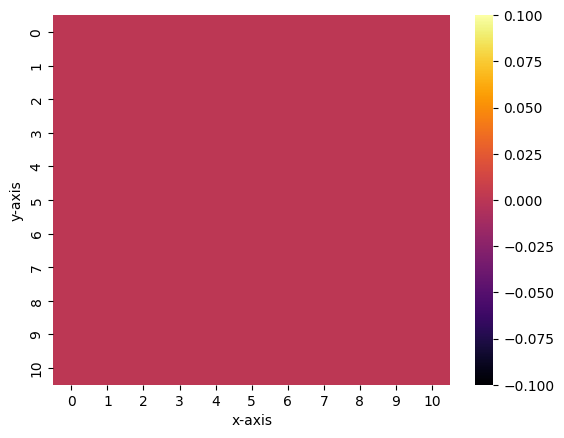

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [72]:
query2array2visuallize(q1)

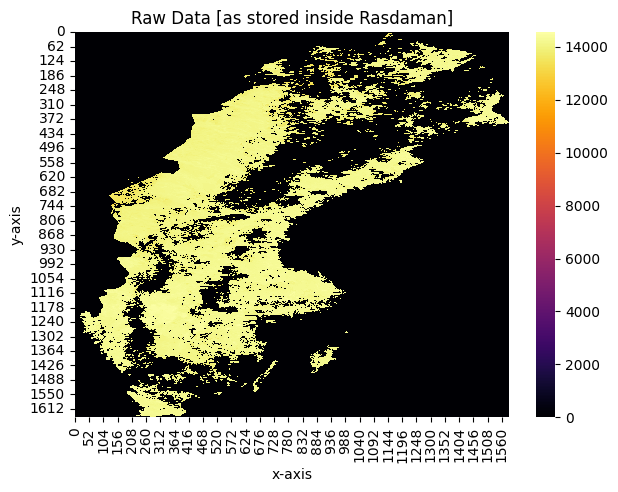

In [84]:
arr = query2array2visuallize(q2, "Raw Data [as stored inside Rasdaman]")

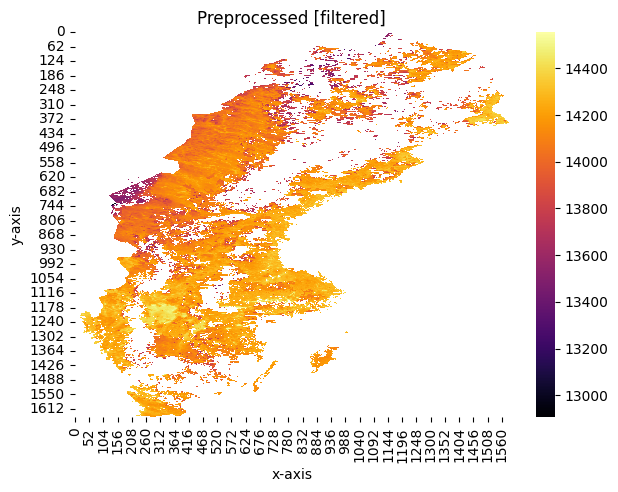

In [76]:
arr = query2array2visuallize(q2, "Preprocessed [filtered]", 0)

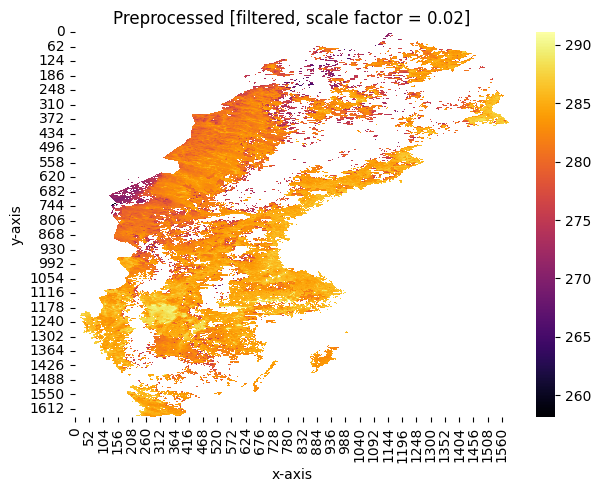

In [77]:
arr = query2array2visuallize(q3, "Preprocessed [filtered, scale factor = 0.02]", 0)

In [78]:
query2result(q6)

3.6421253738942254
<class 'rasdapy.models.result_array.ResultArray'>


In [82]:
query2result(q7)

279.98762699937754
<class 'rasdapy.models.result_array.ResultArray'>


## Case 1: Linköping 

In [93]:
gridPOLYGON

'POLYGON ((519 1312, 520 1312, 521 1312, 521 1311, 522 1311, 523 1311, 524 1311, 525 1311, 525 1311, 524 1310, 525 1310, 525 1310, 526 1310, 526 1309, 527 1309, 528 1309, 528 1308, 529 1308, 530 1308, 530 1308, 529 1308, 529 1307, 529 1307, 529 1306, 530 1306, 530 1306, 530 1305, 530 1305, 530 1304, 530 1304, 530 1303, 530 1302, 530 1302, 529 1302, 528 1301, 528 1301, 528 1300, 528 1300, 528 1299, 529 1299, 529 1299, 529 1298, 529 1298, 529 1297, 529 1297, 528 1297, 528 1296, 528 1296, 527 1296, 527 1295, 526 1294, 526 1294, 525 1294, 525 1293, 525 1293, 526 1293, 526 1292, 526 1292, 526 1291, 527 1291, 527 1291, 527 1290, 528 1290, 528 1290, 528 1289, 528 1289, 529 1288, 529 1288, 529 1287, 529 1287, 528 1286, 527 1286, 526 1286, 525 1286, 524 1286, 524 1286, 525 1286, 525 1285, 526 1285, 526 1285, 526 1284, 526 1284, 526 1283, 527 1283, 527 1283, 527 1282, 527 1282, 527 1281, 526 1281, 526 1280, 525 1281, 524 1281, 523 1281, 522 1281, 522 1281, 521 1281, 520 1281, 519 1281, 518 1281,

In [88]:
q10 = "select clip(m[100:200, 0:* , 0:*], POLYGON ((519 1312, 520 1312, 521 1312, 521 1311, 522 1311, 523 1311, 524 1311, 525 1311, 525 1311, 524 1310, 525 1310, 525 1310, 526 1310, 526 1309, 527 1309, 528 1309, 528 1308, 529 1308, 530 1308, 530 1308, 529 1308, 529 1307, 529 1307, 529 1306, 530 1306, 530 1306, 530 1305, 530 1305, 530 1304, 530 1304, 530 1303, 530 1302, 530 1302, 529 1302, 528 1301, 528 1301, 528 1300, 528 1300, 528 1299, 529 1299, 529 1299, 529 1298, 529 1298, 529 1297, 529 1297, 528 1297, 528 1296, 528 1296, 527 1296, 527 1295, 526 1294, 526 1294, 525 1294, 525 1293, 525 1293, 526 1293, 526 1292, 526 1292, 526 1291, 527 1291, 527 1291, 527 1290, 528 1290, 528 1290, 528 1289, 528 1289, 529 1288, 529 1288, 529 1287, 529 1287, 528 1286, 527 1286, 526 1286, 525 1286, 524 1286, 524 1286, 525 1286, 525 1285, 526 1285, 526 1285, 526 1284, 526 1284, 526 1283, 527 1283, 527 1283, 527 1282, 527 1282, 527 1281, 526 1281, 526 1280, 525 1281, 524 1281, 523 1281, 522 1281, 522 1281, 521 1281, 520 1281, 519 1281, 518 1281, 517 1281, 516 1281, 516 1280, 516 1280, 516 1279, 517 1279, 517 1279, 518 1279, 519 1279, 520 1279, 520 1278, 521 1278, 521 1277, 521 1277, 522 1277, 522 1276, 522 1276, 523 1276, 523 1275, 523 1275, 524 1275, 525 1275, 526 1275, 526 1274, 527 1274, 528 1274, 528 1273, 528 1273, 529 1273, 530 1273, 531 1273, 532 1273, 532 1272, 532 1272, 531 1272, 530 1272, 529 1272, 529 1271, 530 1271, 531 1271, 531 1271, 530 1271, 529 1270, 529 1270, 529 1269, 529 1268, 529 1268, 529 1267, 529 1267, 530 1267, 530 1266, 530 1266, 530 1265, 530 1265, 531 1265, 531 1264, 531 1264, 531 1263, 531 1262, 529 1263, 529 1262, 530 1262, 530 1261, 530 1261, 530 1260, 530 1260, 530 1259, 531 1259, 531 1259, 531 1258, 530 1258, 530 1258, 530 1257, 531 1257, 531 1257, 531 1256, 532 1256, 532 1255, 532 1255, 531 1255, 530 1254, 530 1254, 529 1254, 529 1253, 530 1253, 530 1253, 530 1252, 531 1252, 531 1252, 532 1252, 532 1251, 533 1251, 533 1250, 534 1250, 535 1250, 536 1250, 536 1251, 537 1251, 537 1251, 538 1251, 538 1252, 539 1252, 540 1252, 541 1252, 541 1253, 542 1253, 542 1252, 543 1252, 544 1252, 545 1252, 546 1252, 546 1252, 547 1252, 548 1252, 549 1252, 550 1252, 550 1252, 549 1252, 549 1253, 549 1253, 549 1254, 549 1254, 548 1254, 548 1255, 548 1255, 548 1256, 549 1256, 550 1256, 550 1255, 551 1255, 552 1255, 552 1255, 553 1255, 553 1254, 553 1254, 554 1254, 554 1253, 554 1252, 554 1252, 555 1252, 555 1252, 556 1252, 557 1252, 557 1253, 557 1253, 558 1253, 558 1254, 558 1254, 559 1255, 559 1256, 560 1256, 560 1255, 561 1255, 562 1255, 562 1255, 563 1255, 563 1256, 563 1256, 563 1257, 563 1258, 564 1258, 564 1258, 564 1259, 565 1259, 565 1259, 566 1259, 567 1259, 567 1260, 567 1260, 568 1261, 568 1261, 569 1261, 569 1262, 570 1262, 571 1262, 571 1262, 572 1262, 573 1262, 574 1262, 575 1262, 576 1262, 576 1263, 576 1263, 576 1264, 576 1264, 576 1265, 576 1265, 576 1266, 577 1266, 577 1267, 578 1267, 579 1267, 580 1267, 581 1267, 581 1266, 582 1266, 583 1266, 584 1266, 585 1266, 586 1266, 586 1267, 587 1266, 588 1266, 588 1267, 589 1267, 589 1266, 590 1266, 591 1266, 592 1266, 592 1267, 593 1267, 594 1267, 595 1267, 595 1267, 595 1268, 596 1268, 596 1268, 596 1269, 597 1269, 595 1269, 594 1269, 593 1269, 593 1270, 594 1271, 595 1271, 595 1271, 596 1271, 596 1272, 597 1272, 598 1272, 598 1272, 599 1272, 600 1272, 600 1273, 600 1273, 600 1274, 601 1274, 601 1274, 601 1275, 601 1275, 600 1275, 600 1276, 599 1276, 599 1276, 599 1277, 600 1277, 601 1277, 602 1277, 603 1277, 604 1277, 605 1277, 605 1278, 606 1278, 606 1278, 606 1279, 606 1279, 607 1279, 608 1279, 609 1279, 609 1280, 609 1280, 609 1281, 610 1281, 610 1281, 610 1282, 611 1282, 611 1282, 611 1283, 613 1283, 613 1283, 612 1284, 611 1284, 609 1284, 610 1284, 609 1284, 608 1284, 608 1285, 607 1285, 606 1285, 605 1284, 604 1284, 604 1285, 605 1285, 604 1285, 602 1285, 603 1286, 602 1286, 601 1286, 599 1286, 600 1287, 600 1287, 601 1287, 601 1288, 600 1288, 599 1288, 598 1288, 598 1288, 597 1288, 597 1288, 596 1288, 596 1287, 594 1287, 593 1287, 593 1287, 592 1287, 592 1287, 592 1288, 591 1288, 592 1288, 591 1288, 589 1289, 588 1289, 587 1289, 587 1289, 586 1289, 585 1289, 586 1290, 584 1290, 585 1290, 584 1290, 584 1291, 583 1291, 583 1290, 581 1290, 582 1291, 582 1291, 582 1292, 582 1293, 583 1293, 583 1293, 582 1293, 582 1294, 581 1294, 581 1294, 582 1294, 582 1295, 583 1295, 583 1295, 584 1295, 584 1296, 584 1296, 585 1296, 585 1297, 584 1297, 584 1297, 584 1298, 583 1298, 583 1298, 584 1299, 584 1300, 585 1299, 585 1300, 585 1301, 586 1301, 586 1301, 585 1301, 585 1302, 585 1302, 585 1303, 584 1303, 584 1303, 583 1303, 582 1303, 581 1303, 580 1303, 580 1304, 579 1304, 578 1304, 577 1304, 577 1305, 576 1305, 576 1305, 575 1305, 575 1306, 574 1306, 573 1306, 573 1305, 572 1305, 571 1305, 571 1305, 570 1305, 570 1305, 569 1305, 569 1306, 570 1306, 570 1306, 570 1307, 570 1308, 570 1308, 569 1308, 568 1308, 567 1308, 567 1309, 566 1309, 565 1309, 564 1309, 563 1309, 563 1308, 563 1308, 563 1307, 563 1307, 562 1307, 562 1306, 561 1306, 560 1306, 560 1306, 559 1306, 558 1306, 557 1306, 556 1306, 556 1305, 555 1305, 554 1305, 553 1305, 553 1304, 552 1304, 551 1304, 551 1305, 552 1305, 552 1306, 552 1307, 552 1307, 552 1308, 552 1308, 551 1308, 551 1309, 551 1309, 551 1310, 551 1310, 551 1311, 551 1311, 550 1311, 550 1312, 549 1312, 549 1313, 548 1313, 548 1313, 547 1313, 547 1314, 546 1314, 546 1314, 547 1315, 546 1315, 546 1315, 547 1315, 547 1316, 547 1316, 547 1317, 547 1318, 546 1318, 546 1318, 545 1318, 544 1318, 544 1319, 543 1319, 543 1319, 542 1319, 541 1319, 541 1320, 540 1320, 540 1319, 539 1319, 539 1319, 539 1318, 540 1318, 540 1318, 539 1318, 538 1318, 537 1318, 537 1318, 537 1319, 537 1320, 536 1320, 536 1320, 535 1320, 535 1321, 534 1321, 533 1321, 532 1321, 531 1321, 530 1321, 530 1320, 530 1320, 530 1319, 531 1319, 531 1319, 530 1319, 529 1319, 528 1319, 528 1318, 527 1318, 526 1318, 526 1317, 526 1317, 526 1316, 525 1316, 524 1316, 523 1316, 522 1316, 522 1316, 521 1316, 520 1316, 520 1315, 520 1315, 520 1314, 519 1314, 519 1314, 519 1313, 519 1313, 519 1312))) from Surface_Temperature_Sweden as m" 
query2array2visuallize(q10, "Preprocessed [Linköping]", 0)

Exception: Error executing query 'select clip(m[100:200, 0:* , 0:*], POLYGON ((519 1312, 520 1312, 521 1312, 521 1311, 522 1311, 523 1311, 524 1311, 525 1311, 525 1311, 524 1310, 525 1310, 525 1310, 526 1310, 526 1309, 527 1309, 528 1309, 528 1308, 529 1308, 530 1308, 530 1308, 529 1308, 529 1307, 529 1307, 529 1306, 530 1306, 530 1306, 530 1305, 530 1305, 530 1304, 530 1304, 530 1303, 530 1302, 530 1302, 529 1302, 528 1301, 528 1301, 528 1300, 528 1300, 528 1299, 529 1299, 529 1299, 529 1298, 529 1298, 529 1297, 529 1297, 528 1297, 528 1296, 528 1296, 527 1296, 527 1295, 526 1294, 526 1294, 525 1294, 525 1293, 525 1293, 526 1293, 526 1292, 526 1292, 526 1291, 527 1291, 527 1291, 527 1290, 528 1290, 528 1290, 528 1289, 528 1289, 529 1288, 529 1288, 529 1287, 529 1287, 528 1286, 527 1286, 526 1286, 525 1286, 524 1286, 524 1286, 525 1286, 525 1285, 526 1285, 526 1285, 526 1284, 526 1284, 526 1283, 527 1283, 527 1283, 527 1282, 527 1282, 527 1281, 526 1281, 526 1280, 525 1281, 524 1281, 523 1281, 522 1281, 522 1281, 521 1281, 520 1281, 519 1281, 518 1281, 517 1281, 516 1281, 516 1280, 516 1280, 516 1279, 517 1279, 517 1279, 518 1279, 519 1279, 520 1279, 520 1278, 521 1278, 521 1277, 521 1277, 522 1277, 522 1276, 522 1276, 523 1276, 523 1275, 523 1275, 524 1275, 525 1275, 526 1275, 526 1274, 527 1274, 528 1274, 528 1273, 528 1273, 529 1273, 530 1273, 531 1273, 532 1273, 532 1272, 532 1272, 531 1272, 530 1272, 529 1272, 529 1271, 530 1271, 531 1271, 531 1271, 530 1271, 529 1270, 529 1270, 529 1269, 529 1268, 529 1268, 529 1267, 529 1267, 530 1267, 530 1266, 530 1266, 530 1265, 530 1265, 531 1265, 531 1264, 531 1264, 531 1263, 531 1262, 529 1263, 529 1262, 530 1262, 530 1261, 530 1261, 530 1260, 530 1260, 530 1259, 531 1259, 531 1259, 531 1258, 530 1258, 530 1258, 530 1257, 531 1257, 531 1257, 531 1256, 532 1256, 532 1255, 532 1255, 531 1255, 530 1254, 530 1254, 529 1254, 529 1253, 530 1253, 530 1253, 530 1252, 531 1252, 531 1252, 532 1252, 532 1251, 533 1251, 533 1250, 534 1250, 535 1250, 536 1250, 536 1251, 537 1251, 537 1251, 538 1251, 538 1252, 539 1252, 540 1252, 541 1252, 541 1253, 542 1253, 542 1252, 543 1252, 544 1252, 545 1252, 546 1252, 546 1252, 547 1252, 548 1252, 549 1252, 550 1252, 550 1252, 549 1252, 549 1253, 549 1253, 549 1254, 549 1254, 548 1254, 548 1255, 548 1255, 548 1256, 549 1256, 550 1256, 550 1255, 551 1255, 552 1255, 552 1255, 553 1255, 553 1254, 553 1254, 554 1254, 554 1253, 554 1252, 554 1252, 555 1252, 555 1252, 556 1252, 557 1252, 557 1253, 557 1253, 558 1253, 558 1254, 558 1254, 559 1255, 559 1256, 560 1256, 560 1255, 561 1255, 562 1255, 562 1255, 563 1255, 563 1256, 563 1256, 563 1257, 563 1258, 564 1258, 564 1258, 564 1259, 565 1259, 565 1259, 566 1259, 567 1259, 567 1260, 567 1260, 568 1261, 568 1261, 569 1261, 569 1262, 570 1262, 571 1262, 571 1262, 572 1262, 573 1262, 574 1262, 575 1262, 576 1262, 576 1263, 576 1263, 576 1264, 576 1264, 576 1265, 576 1265, 576 1266, 577 1266, 577 1267, 578 1267, 579 1267, 580 1267, 581 1267, 581 1266, 582 1266, 583 1266, 584 1266, 585 1266, 586 1266, 586 1267, 587 1266, 588 1266, 588 1267, 589 1267, 589 1266, 590 1266, 591 1266, 592 1266, 592 1267, 593 1267, 594 1267, 595 1267, 595 1267, 595 1268, 596 1268, 596 1268, 596 1269, 597 1269, 595 1269, 594 1269, 593 1269, 593 1270, 594 1271, 595 1271, 595 1271, 596 1271, 596 1272, 597 1272, 598 1272, 598 1272, 599 1272, 600 1272, 600 1273, 600 1273, 600 1274, 601 1274, 601 1274, 601 1275, 601 1275, 600 1275, 600 1276, 599 1276, 599 1276, 599 1277, 600 1277, 601 1277, 602 1277, 603 1277, 604 1277, 605 1277, 605 1278, 606 1278, 606 1278, 606 1279, 606 1279, 607 1279, 608 1279, 609 1279, 609 1280, 609 1280, 609 1281, 610 1281, 610 1281, 610 1282, 611 1282, 611 1282, 611 1283, 613 1283, 613 1283, 612 1284, 611 1284, 609 1284, 610 1284, 609 1284, 608 1284, 608 1285, 607 1285, 606 1285, 605 1284, 604 1284, 604 1285, 605 1285, 604 1285, 602 1285, 603 1286, 602 1286, 601 1286, 599 1286, 600 1287, 600 1287, 601 1287, 601 1288, 600 1288, 599 1288, 598 1288, 598 1288, 597 1288, 597 1288, 596 1288, 596 1287, 594 1287, 593 1287, 593 1287, 592 1287, 592 1287, 592 1288, 591 1288, 592 1288, 591 1288, 589 1289, 588 1289, 587 1289, 587 1289, 586 1289, 585 1289, 586 1290, 584 1290, 585 1290, 584 1290, 584 1291, 583 1291, 583 1290, 581 1290, 582 1291, 582 1291, 582 1292, 582 1293, 583 1293, 583 1293, 582 1293, 582 1294, 581 1294, 581 1294, 582 1294, 582 1295, 583 1295, 583 1295, 584 1295, 584 1296, 584 1296, 585 1296, 585 1297, 584 1297, 584 1297, 584 1298, 583 1298, 583 1298, 584 1299, 584 1300, 585 1299, 585 1300, 585 1301, 586 1301, 586 1301, 585 1301, 585 1302, 585 1302, 585 1303, 584 1303, 584 1303, 583 1303, 582 1303, 581 1303, 580 1303, 580 1304, 579 1304, 578 1304, 577 1304, 577 1305, 576 1305, 576 1305, 575 1305, 575 1306, 574 1306, 573 1306, 573 1305, 572 1305, 571 1305, 571 1305, 570 1305, 570 1305, 569 1305, 569 1306, 570 1306, 570 1306, 570 1307, 570 1308, 570 1308, 569 1308, 568 1308, 567 1308, 567 1309, 566 1309, 565 1309, 564 1309, 563 1309, 563 1308, 563 1308, 563 1307, 563 1307, 562 1307, 562 1306, 561 1306, 560 1306, 560 1306, 559 1306, 558 1306, 557 1306, 556 1306, 556 1305, 555 1305, 554 1305, 553 1305, 553 1304, 552 1304, 551 1304, 551 1305, 552 1305, 552 1306, 552 1307, 552 1307, 552 1308, 552 1308, 551 1308, 551 1309, 551 1309, 551 1310, 551 1310, 551 1311, 551 1311, 550 1311, 550 1312, 549 1312, 549 1313, 548 1313, 548 1313, 547 1313, 547 1314, 546 1314, 546 1314, 547 1315, 546 1315, 546 1315, 547 1315, 547 1316, 547 1316, 547 1317, 547 1318, 546 1318, 546 1318, 545 1318, 544 1318, 544 1319, 543 1319, 543 1319, 542 1319, 541 1319, 541 1320, 540 1320, 540 1319, 539 1319, 539 1319, 539 1318, 540 1318, 540 1318, 539 1318, 538 1318, 537 1318, 537 1318, 537 1319, 537 1320, 536 1320, 536 1320, 535 1320, 535 1321, 534 1321, 533 1321, 532 1321, 531 1321, 530 1321, 530 1320, 530 1320, 530 1319, 531 1319, 531 1319, 530 1319, 529 1319, 528 1319, 528 1318, 527 1318, 526 1318, 526 1317, 526 1317, 526 1316, 525 1316, 524 1316, 523 1316, 522 1316, 522 1316, 521 1316, 520 1316, 520 1315, 520 1315, 520 1314, 519 1314, 519 1314, 519 1313, 519 1313, 519 1312))) from Surface_Temperature_Sweden as m', error message 'rasdaman error 507: Exception: The dimension of the points differs from that of the MDD object in which they are expected to lie.'

In [91]:
q11 = "select avg_cells(clip(m[100, 0:* , 0:*]*0.02, POLYGON ((519 1312, 520 1312, 521 1312, 521 1311, 522 1311, 523 1311, 524 1311, 525 1311, 525 1311, 524 1310, 525 1310, 525 1310, 526 1310, 526 1309, 527 1309, 528 1309, 528 1308, 529 1308, 530 1308, 530 1308, 529 1308, 529 1307, 529 1307, 529 1306, 530 1306, 530 1306, 530 1305, 530 1305, 530 1304, 530 1304, 530 1303, 530 1302, 530 1302, 529 1302, 528 1301, 528 1301, 528 1300, 528 1300, 528 1299, 529 1299, 529 1299, 529 1298, 529 1298, 529 1297, 529 1297, 528 1297, 528 1296, 528 1296, 527 1296, 527 1295, 526 1294, 526 1294, 525 1294, 525 1293, 525 1293, 526 1293, 526 1292, 526 1292, 526 1291, 527 1291, 527 1291, 527 1290, 528 1290, 528 1290, 528 1289, 528 1289, 529 1288, 529 1288, 529 1287, 529 1287, 528 1286, 527 1286, 526 1286, 525 1286, 524 1286, 524 1286, 525 1286, 525 1285, 526 1285, 526 1285, 526 1284, 526 1284, 526 1283, 527 1283, 527 1283, 527 1282, 527 1282, 527 1281, 526 1281, 526 1280, 525 1281, 524 1281, 523 1281, 522 1281, 522 1281, 521 1281, 520 1281, 519 1281, 518 1281, 517 1281, 516 1281, 516 1280, 516 1280, 516 1279, 517 1279, 517 1279, 518 1279, 519 1279, 520 1279, 520 1278, 521 1278, 521 1277, 521 1277, 522 1277, 522 1276, 522 1276, 523 1276, 523 1275, 523 1275, 524 1275, 525 1275, 526 1275, 526 1274, 527 1274, 528 1274, 528 1273, 528 1273, 529 1273, 530 1273, 531 1273, 532 1273, 532 1272, 532 1272, 531 1272, 530 1272, 529 1272, 529 1271, 530 1271, 531 1271, 531 1271, 530 1271, 529 1270, 529 1270, 529 1269, 529 1268, 529 1268, 529 1267, 529 1267, 530 1267, 530 1266, 530 1266, 530 1265, 530 1265, 531 1265, 531 1264, 531 1264, 531 1263, 531 1262, 529 1263, 529 1262, 530 1262, 530 1261, 530 1261, 530 1260, 530 1260, 530 1259, 531 1259, 531 1259, 531 1258, 530 1258, 530 1258, 530 1257, 531 1257, 531 1257, 531 1256, 532 1256, 532 1255, 532 1255, 531 1255, 530 1254, 530 1254, 529 1254, 529 1253, 530 1253, 530 1253, 530 1252, 531 1252, 531 1252, 532 1252, 532 1251, 533 1251, 533 1250, 534 1250, 535 1250, 536 1250, 536 1251, 537 1251, 537 1251, 538 1251, 538 1252, 539 1252, 540 1252, 541 1252, 541 1253, 542 1253, 542 1252, 543 1252, 544 1252, 545 1252, 546 1252, 546 1252, 547 1252, 548 1252, 549 1252, 550 1252, 550 1252, 549 1252, 549 1253, 549 1253, 549 1254, 549 1254, 548 1254, 548 1255, 548 1255, 548 1256, 549 1256, 550 1256, 550 1255, 551 1255, 552 1255, 552 1255, 553 1255, 553 1254, 553 1254, 554 1254, 554 1253, 554 1252, 554 1252, 555 1252, 555 1252, 556 1252, 557 1252, 557 1253, 557 1253, 558 1253, 558 1254, 558 1254, 559 1255, 559 1256, 560 1256, 560 1255, 561 1255, 562 1255, 562 1255, 563 1255, 563 1256, 563 1256, 563 1257, 563 1258, 564 1258, 564 1258, 564 1259, 565 1259, 565 1259, 566 1259, 567 1259, 567 1260, 567 1260, 568 1261, 568 1261, 569 1261, 569 1262, 570 1262, 571 1262, 571 1262, 572 1262, 573 1262, 574 1262, 575 1262, 576 1262, 576 1263, 576 1263, 576 1264, 576 1264, 576 1265, 576 1265, 576 1266, 577 1266, 577 1267, 578 1267, 579 1267, 580 1267, 581 1267, 581 1266, 582 1266, 583 1266, 584 1266, 585 1266, 586 1266, 586 1267, 587 1266, 588 1266, 588 1267, 589 1267, 589 1266, 590 1266, 591 1266, 592 1266, 592 1267, 593 1267, 594 1267, 595 1267, 595 1267, 595 1268, 596 1268, 596 1268, 596 1269, 597 1269, 595 1269, 594 1269, 593 1269, 593 1270, 594 1271, 595 1271, 595 1271, 596 1271, 596 1272, 597 1272, 598 1272, 598 1272, 599 1272, 600 1272, 600 1273, 600 1273, 600 1274, 601 1274, 601 1274, 601 1275, 601 1275, 600 1275, 600 1276, 599 1276, 599 1276, 599 1277, 600 1277, 601 1277, 602 1277, 603 1277, 604 1277, 605 1277, 605 1278, 606 1278, 606 1278, 606 1279, 606 1279, 607 1279, 608 1279, 609 1279, 609 1280, 609 1280, 609 1281, 610 1281, 610 1281, 610 1282, 611 1282, 611 1282, 611 1283, 613 1283, 613 1283, 612 1284, 611 1284, 609 1284, 610 1284, 609 1284, 608 1284, 608 1285, 607 1285, 606 1285, 605 1284, 604 1284, 604 1285, 605 1285, 604 1285, 602 1285, 603 1286, 602 1286, 601 1286, 599 1286, 600 1287, 600 1287, 601 1287, 601 1288, 600 1288, 599 1288, 598 1288, 598 1288, 597 1288, 597 1288, 596 1288, 596 1287, 594 1287, 593 1287, 593 1287, 592 1287, 592 1287, 592 1288, 591 1288, 592 1288, 591 1288, 589 1289, 588 1289, 587 1289, 587 1289, 586 1289, 585 1289, 586 1290, 584 1290, 585 1290, 584 1290, 584 1291, 583 1291, 583 1290, 581 1290, 582 1291, 582 1291, 582 1292, 582 1293, 583 1293, 583 1293, 582 1293, 582 1294, 581 1294, 581 1294, 582 1294, 582 1295, 583 1295, 583 1295, 584 1295, 584 1296, 584 1296, 585 1296, 585 1297, 584 1297, 584 1297, 584 1298, 583 1298, 583 1298, 584 1299, 584 1300, 585 1299, 585 1300, 585 1301, 586 1301, 586 1301, 585 1301, 585 1302, 585 1302, 585 1303, 584 1303, 584 1303, 583 1303, 582 1303, 581 1303, 580 1303, 580 1304, 579 1304, 578 1304, 577 1304, 577 1305, 576 1305, 576 1305, 575 1305, 575 1306, 574 1306, 573 1306, 573 1305, 572 1305, 571 1305, 571 1305, 570 1305, 570 1305, 569 1305, 569 1306, 570 1306, 570 1306, 570 1307, 570 1308, 570 1308, 569 1308, 568 1308, 567 1308, 567 1309, 566 1309, 565 1309, 564 1309, 563 1309, 563 1308, 563 1308, 563 1307, 563 1307, 562 1307, 562 1306, 561 1306, 560 1306, 560 1306, 559 1306, 558 1306, 557 1306, 556 1306, 556 1305, 555 1305, 554 1305, 553 1305, 553 1304, 552 1304, 551 1304, 551 1305, 552 1305, 552 1306, 552 1307, 552 1307, 552 1308, 552 1308, 551 1308, 551 1309, 551 1309, 551 1310, 551 1310, 551 1311, 551 1311, 550 1311, 550 1312, 549 1312, 549 1313, 548 1313, 548 1313, 547 1313, 547 1314, 546 1314, 546 1314, 547 1315, 546 1315, 546 1315, 547 1315, 547 1316, 547 1316, 547 1317, 547 1318, 546 1318, 546 1318, 545 1318, 544 1318, 544 1319, 543 1319, 543 1319, 542 1319, 541 1319, 541 1320, 540 1320, 540 1319, 539 1319, 539 1319, 539 1318, 540 1318, 540 1318, 539 1318, 538 1318, 537 1318, 537 1318, 537 1319, 537 1320, 536 1320, 536 1320, 535 1320, 535 1321, 534 1321, 533 1321, 532 1321, 531 1321, 530 1321, 530 1320, 530 1320, 530 1319, 531 1319, 531 1319, 530 1319, 529 1319, 528 1319, 528 1318, 527 1318, 526 1318, 526 1317, 526 1317, 526 1316, 525 1316, 524 1316, 523 1316, 522 1316, 522 1316, 521 1316, 520 1316, 520 1315, 520 1315, 520 1314, 519 1314, 519 1314, 519 1313, 519 1313, 519 1312)))) from Surface_Temperature_Sweden as m" 
query2result(q11)

285.6290847457623
<class 'rasdapy.models.result_array.ResultArray'>


### Need to validate the result